# CAPSTONE - MSBA - FALL 2024

# EDA NOTEBOOK

## Author:  Nishigandha Tayade

### Table of Contents

1. [Introduction](#1-Introduction)  
2. [Data Description](#2-Data-Description)  
3. [Loading Libraries](#3-Loading-Libraries)  
4. [Importing Dataset](#4-Importing-Dataset)  
5. [Data Cleaning and Manipulation](#5-Data-Cleaning-and-Manipulation)  
6. [Feature Engineering](#6-Feature-Engineering)  
7. [Modeling](#7-Modeling)  
   i. [Model 1 - Latent Dirichlet Allocation](#7i-Model-1---Latent-Dirichlet-Allocation)  
   ii. [Model 2 - Survival Analysis](#7ii-Model-2---Survival-Analysis)


## 1. Introduction


#### **Project Goal**
The goal of this project is to develop a comprehensive understanding of the maintenance activities across various production locations within the organization. Specifically, the focus is on analyzing planned and unplanned maintenance activities to identify patterns and potential areas for operational improvements. This analysis will aid in forecasting machine downtimes more accurately and help in improving preventive maintenance strategies.

#### **Business Problem**
The business problem centers around improving machine reliability and reducing unplanned downtimes, which lead to significant operational inefficiencies and financial losses. By identifying the factors contributing to unplanned maintenance events and comparing them to planned maintenance activities, the organization can enhance its maintenance scheduling and inventory management.

#### **Analytical Problem**
From an analytical perspective, this project aims to:
1. Quantify the distribution of planned and unplanned maintenance activities across different production locations.
2. Explore the relationship between various maintenance attributes, such as maintenance type, location, and frequency, to better understand the factors leading to equipment breakdowns.

#### **Purpose of the Notebook**
The purpose of this Exploratory Data Analysis (EDA) notebook is to investigate and summarize the characteristics of the data, focusing on:
- The distribution of planned vs. unplanned maintenance activities.
- The patterns of maintenance events across production locations.
- The anomalies or inconsistencies in data recording (e.g., maintenance plans associated with unplanned activities).
- The frequency and impact of various maintenance types.

By addressing these questions, the EDA will help uncover insights that can guide future predictive modeling efforts aimed at minimizing unplanned downtimes and optimizing machine maintenance schedules.


## 2. Data Description

#### **i. Maintenance and Downtime Tracking**

The dataset records work orders issued for machine maintenance across various production plants. Each work order represents an instance where a machine required attention, either due to planned maintenance or an unplanned breakdown.

ORDER_ID is a unique identifier that helps track each work order in the system. It ensures that each maintenance event can be distinguished and analyzed individually.

EXECUTION_START_DATE and EXECUTION_FINISH_DATE provide the timeline for when the maintenance work began and ended. These timestamps are crucial for understanding how long machines were down and how quickly repairs were conducted.

ACCTUAL_START_TIME, ACTUAL_FINISH_TIME, and ACTUAL_WORK_IN_MINUTES give a more granular breakdown of the specific time taken to fix a machine, offering insights into the efficiency of the maintenance process.



#### **ii. Types of Maintenance:**

The dataset captures both planned and unplanned maintenance activities.

MAINTENANCE_PLAN indicates if the work order was part of a scheduled or preventive maintenance plan, aiming to fix a machine before it breaks. A null value suggests that the maintenance was unplanned (corrective maintenance).

MAINTENANCE_ACTIVITY_TYPE provides further classification, differentiating between preventive maintenance (work conducted to prevent issues before they happen) and corrective maintenance (repairs conducted after a machine has already failed).



#### **iii. Equipment and Functional Location:**

The dataset also provides detailed information about the equipment involved and its location within the plant.

PLANT_ID and PRODUCTION_LOCATION identify the specific production plant where the maintenance took place. This information is essential for comparing performance across different plants and understanding if certain locations experience more downtimes.

FUNCTIONAL_LOC and related columns (e.g., FUNCTIONAL_AREA_NODE_X_MODIFIED) break down the location of the equipment into detailed segments such as the production line, subprocess, and even specific machines. This hierarchical structure helps pinpoint exactly which part of the production line experienced downtime.

EQUIPMENT_ID and EQUIPMENT_DESC5 identify the specific equipment or machine component that required maintenance. Understanding which machines break down most frequently or which parts require the most attention is vital for predictive maintenance.



#### **iv. Maintenance Details:**
Each work order includes details on the nature of the maintenance conducted.

ORDER_DESCRIPTION contains a textual description of the maintenance activity, explaining what work was carried out and potentially the cause of the issue. This information could be used for text analysis to identify common problems.

MAINTENANCE_TYPE_DESCRIPTION categorizes the maintenance activity as either preventive or corrective, providing an additional layer of insight into whether the work was aimed at fixing an existing issue or preventing future breakdowns.

#### **v. Predictive Maintenance Potential:**
The data provides a rich foundation for developing predictive maintenance models. By analyzing downtime, maintenance frequency, and parts replacements, it becomes possible to predict when machines are likely to fail and take preemptive action to reduce unplanned downtime.

EQUIP_START_UP_DATE, EQUIP_VALID_FROM, and EQUIP_VALID_TO provide insights into the age and operational lifespan of each machine, which could be correlated with the frequency of breakdowns. Older machines might require more frequent maintenance or exhibit patterns of failure that can be anticipated.



#### **vi. Business Impact:**
Finally, the dataset allows for the calculation of the business impact of machine downtimes.

ACTUAL_WORK_IN_MINUTES represents the amount of time a machine was out of operation, which directly correlates to lost productivity.

By analyzing the frequency and severity of breakdowns, it becomes possible to estimate the opportunity cost—the amount of lost output during machine downtimes—and how predictive maintenance could mitigate this loss.

## 3. Loading Libraries

In [6]:
# Loading Libraries.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 4. Importing Dataset

In [8]:
iwc_df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

In [9]:
print(iwc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

In [10]:
# Viewing General Statistics of the Raw Dataset.
print(iwc_df.describe())

           ORDER_ID  ACTUAL_WORK_IN_MINUTES  MAINTENANCE_ITEM  EQUIPMENT_ID
count  1.427264e+06            1.427264e+06     152594.000000  2.917950e+05
mean   4.561470e+10            8.862968e+01     115846.807954  3.002609e+08
std    8.387114e+10            8.037915e+02      71325.255687  5.581645e+06
min    1.000219e+08            0.000000e+00      39801.000000  2.000871e+08
25%    4.022602e+08            1.200000e+01      41046.000000  3.000092e+08
50%    7.044271e+08            4.800000e+01     112995.000000  3.000178e+08
75%    1.002343e+09            9.000000e+01     134702.000000  3.000269e+08
max    9.000001e+11            3.301848e+05     346352.000000  4.000290e+08


In [11]:
# Calculating Total Missing Values in the Entire Dataset.
total_missing_values = iwc_df.isnull().sum()
print(total_missing_values)

ORDER_ID                                 0
PLANT_ID                                 0
PRODUCTION_LOCATION                      0
EXECUTION_START_DATE                     0
EXECUTION_FINISH_DATE                    0
ACTUAL_START_TIME                        0
ACTUAL_FINISH_TIME                       0
ACTUAL_WORK_IN_MINUTES                   0
MAINTENANCE_PLAN                   1274670
MAINTENANCE_ITEM                   1274670
MAINTENANCE_ACTIVITY_TYPE                0
ORDER_DESCRIPTION                  1135497
MAINTENANCE_TYPE_DESCRIPTION       1135469
FUNCTIONAL_LOC                     1135482
FUNCTIONAL_AREA_NODE_1_MODIFIED    1137147
FUNCTIONAL_AREA_NODE_2_MODIFIED    1144857
FUNCTIONAL_AREA_NODE_3_MODIFIED    1168573
FUNCTIONAL_AREA_NODE_4_MODIFIED    1189691
FUNCTIONAL_AREA_NODE_5_MODIFIED    1425084
EQUIPMENT_ID                       1135469
EQUIPMENT_DESC                     1347817
EQUIP_CAT_DESC                     1347817
EQUIP_START_UP_DATE                1347817
EQUIP_VALID

In [12]:
# Calculation of the percentage of missing values in the entire dataset.
missing_values_percentage = (iwc_df.isnull().sum() / len(iwc_df)) * 100
print(missing_values_percentage)

ORDER_ID                            0.000000
PLANT_ID                            0.000000
PRODUCTION_LOCATION                 0.000000
EXECUTION_START_DATE                0.000000
EXECUTION_FINISH_DATE               0.000000
ACTUAL_START_TIME                   0.000000
ACTUAL_FINISH_TIME                  0.000000
ACTUAL_WORK_IN_MINUTES              0.000000
MAINTENANCE_PLAN                   89.308635
MAINTENANCE_ITEM                   89.308635
MAINTENANCE_ACTIVITY_TYPE           0.000000
ORDER_DESCRIPTION                  79.557601
MAINTENANCE_TYPE_DESCRIPTION       79.555639
FUNCTIONAL_LOC                     79.556550
FUNCTIONAL_AREA_NODE_1_MODIFIED    79.673207
FUNCTIONAL_AREA_NODE_2_MODIFIED    80.213401
FUNCTIONAL_AREA_NODE_3_MODIFIED    81.875042
FUNCTIONAL_AREA_NODE_4_MODIFIED    83.354656
FUNCTIONAL_AREA_NODE_5_MODIFIED    99.847260
EQUIPMENT_ID                       79.555639
EQUIPMENT_DESC                     94.433616
EQUIP_CAT_DESC                     94.433616
EQUIP_STAR

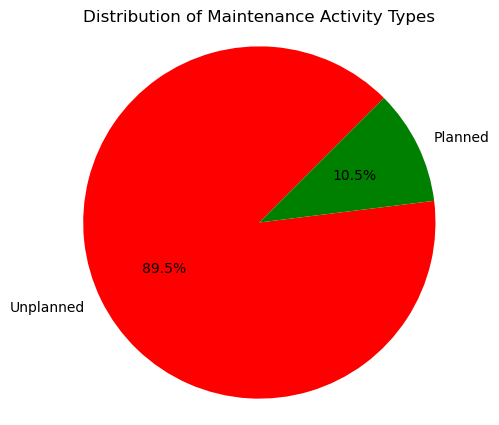

In [13]:
# Counting occurrences of each maintenance activity type
maintenance_activity_counts = iwc_df['MAINTENANCE_ACTIVITY_TYPE'].value_counts()

# Defining custom colors for planned and unplanned maintenance types
colors = ['red', 'green']  # Green for planned, Red for unplanned

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(maintenance_activity_counts, labels=maintenance_activity_counts.index, autopct='%1.1f%%', startangle=45, colors=colors)
plt.title('Distribution of Maintenance Activity Types')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


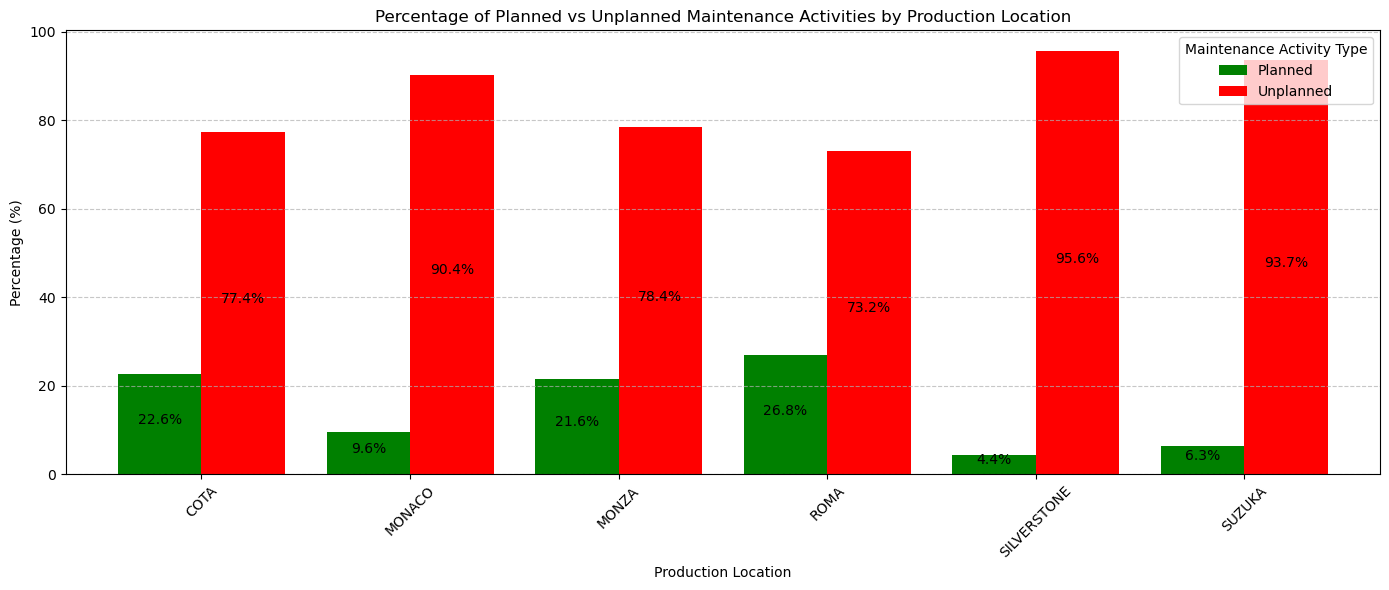

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the data by Production Location and Maintenance Activity Type, then count the occurrences
grouped_data = iwc_df.groupby(['PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE']).size().reset_index(name='Count')

# Calculate the total counts for each production location
total_counts = grouped_data.groupby('PRODUCTION_LOCATION')['Count'].transform('sum')

# Calculate the percentage of each maintenance activity type within each production location
grouped_data['Percentage'] = (grouped_data['Count'] / total_counts) * 100

# Pivot the data to create columns for each maintenance activity type with percentages
pivot_data = grouped_data.pivot(index='PRODUCTION_LOCATION', columns='MAINTENANCE_ACTIVITY_TYPE', values='Percentage').fillna(0)

# Define custom colors for the bars
custom_colors = ['green', 'red']

# Plotting the grouped bar plot with custom colors
ax = pivot_data.plot(kind='bar', figsize=(14, 6), color=custom_colors, width=0.8)
plt.title('Percentage of Planned vs Unplanned Maintenance Activities by Production Location')
plt.xlabel('Production Location')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Maintenance Activity Type', loc='upper right')

# Annotate each bar with percentage values
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, padding=3)

plt.tight_layout()
plt.show()


In [15]:
# Converting Actual_Work_in_Minutes in to Hour to standardize time unit for comparison.

# 1. Generating a copy of the dataframe
iwc_df_copy = iwc_df.copy()

# 2. Converting 'ACTUAL_WORK_IN_MINUTES' into hours and creating a new column
iwc_df_copy['ACTUAL_WORK_IN_HOURS'] = iwc_df_copy['ACTUAL_WORK_IN_MINUTES'] / 60

# 3. Displaying the first few rows to verify the conversion
iwc_df_copy[['ACTUAL_WORK_IN_MINUTES', 'ACTUAL_WORK_IN_HOURS']].head()


,ACTUAL_WORK_IN_MINUTES,ACTUAL_WORK_IN_HOURS
0,390.0,6.5
1,420.0,7.0
2,30.0,0.5
3,60.0,1.0
4,120.0,2.0


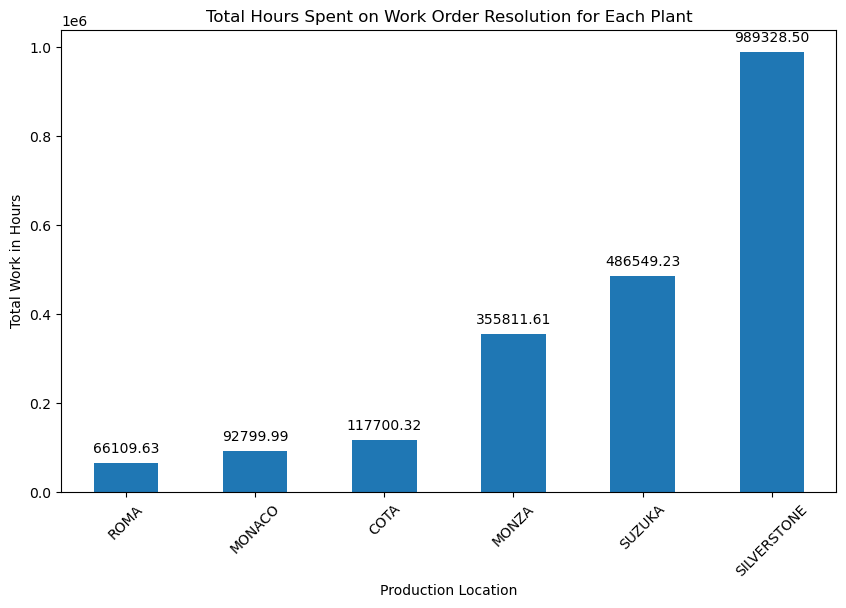

In [16]:
# Visualizing the number of Hours of the Work Orders in each production Plant.

# Grouping by PLANT_ID to sum the 'ACTUAL_WORK_IN_HOURS' for each plant and sorting in ascending order
work_hours_per_plant = iwc_df_copy.groupby('PRODUCTION_LOCATION')['ACTUAL_WORK_IN_HOURS'].sum().sort_values(ascending=True)

# Plotting the graph
plt.figure(figsize=(10,6))
ax = work_hours_per_plant.plot(kind='bar')
plt.title('Total Hours Spent on Work Order Resolution for Each Plant')
plt.xlabel('Production Location')
plt.ylabel('Total Work in Hours')
plt.xticks(rotation=45)

# Adding labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

In [17]:
# Counting the various types of Maintainence Type.
iwc_df_copy['MAINTENANCE_TYPE_DESCRIPTION'].value_counts()

MAINTENANCE_TYPE_DESCRIPTION
Preventive Maintenance Order    151533
Corrective Maintenance Order    134074
Administrative Order              6161
Capital Order                       22
Breakdown Maintenance Order          5
Name: count, dtype: int64

<Figure size 600x300 with 0 Axes>

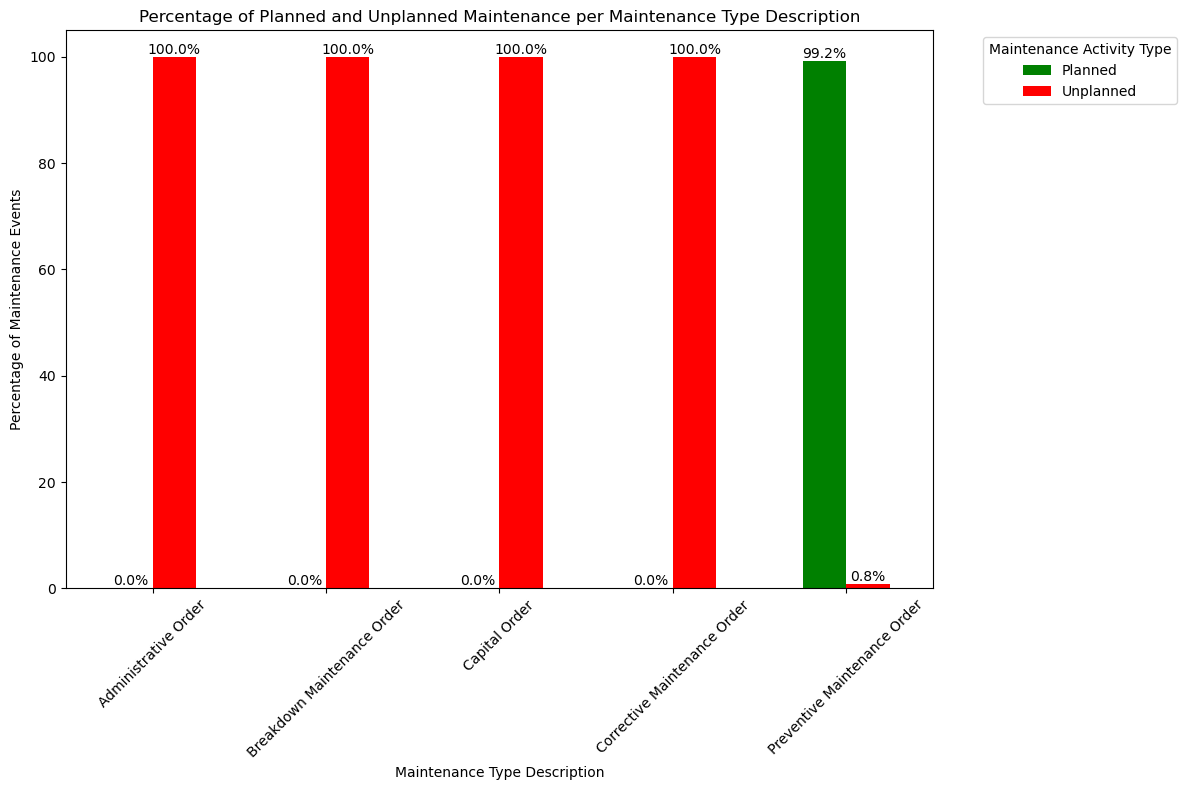

In [18]:
# Grouping by 'MAINTENANCE_TYPE_DESCRIPTION' and 'MAINTENANCE_ACTIVITY_TYPE' and counting occurrences
maintenance_type_activity_counts = iwc_df_copy.groupby(['MAINTENANCE_TYPE_DESCRIPTION', 'MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

# Calculating percentages for each maintenance type description
maintenance_type_activity_percent = maintenance_type_activity_counts.div(maintenance_type_activity_counts.sum(axis=1), axis=0) * 100

# Plotting the grouped bar chart
plt.figure(figsize=(6,3))
ax = maintenance_type_activity_percent.plot(kind='bar', stacked=False, figsize=(12, 8), color=['green', 'red'])

plt.title('Percentage of Planned and Unplanned Maintenance per Maintenance Type Description')
plt.xlabel('Maintenance Type Description')
plt.ylabel('Percentage of Maintenance Events')
plt.xticks(rotation=45)

# Adding percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.legend(title='Maintenance Activity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**INTERPRETATION:**

As we observe that there are almost 80% missing values in the variable "Maintenance_Type_Description", we need to impute the missing values with "Breakdown Maintenance Order" as the count of the same is just 5 entries in the total dataset and as per the above graph all are unplanned maintainence activites, hence it is logical to impute all the missing values with "Breakdown Maintenance Order" as we are aiming to reduced the downtime of the machine by forecasting the breaking of the machine accurately.

In [20]:
# Imputation of Missing Values of " Maintenance_Type_Description" (80% Missing Values)

# Checking for missing values in the 'MAINTENANCE_TYPE_DESCRIPTION' column
print(iwc_df_copy['MAINTENANCE_TYPE_DESCRIPTION'].isnull().sum())

# Imputing missing values with 'Breakdown Maintenance Order'
iwc_df_copy['MAINTENANCE_TYPE_DESCRIPTION'].fillna('Breakdown Maintenance Order', inplace=True)

# Verifying the imputation
print(iwc_df_copy['MAINTENANCE_TYPE_DESCRIPTION'].isnull().sum())


1135469
0


C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\4440480.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  iwc_df_copy['MAINTENANCE_TYPE_DESCRIPTION'].fillna('Breakdown Maintenance Order', inplace=True)


In [21]:
# Checking for rows where MAINTENANCE_ACTIVITY_TYPE is 'Unplanned' but 'MAINTENANCE_PLAN' is not null
unplanned_with_plan = iwc_df_copy[(iwc_df_copy['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned') & (iwc_df_copy['MAINTENANCE_PLAN'].notnull())]

# Counting such instances distributed over the production location
unplanned_with_plan_by_location = unplanned_with_plan.groupby('PRODUCTION_LOCATION').size()

# Display the result
print(unplanned_with_plan_by_location)


PRODUCTION_LOCATION
COTA              4
MONZA          2118
ROMA             33
SILVERSTONE      49
SUZUKA            3
dtype: int64


**Interpretation:**

According to the data dictionary, when the `MAINTENANCE_PLAN` is null, the event should be categorized as unplanned, and vice versa. However, upon reviewing the data, we identified 2,207 instances where unplanned maintenance events were incorrectly associated with a maintenance plan, distributed across the six production locations. This discrepancy indicates potential inaccuracies in the way work orders are recorded at these production plants. These cases warrant special attention, as they suggest abnormal behavior in what should have been "planned breakdowns." While this variable may not be directly useful for modeling, as the relevant information is already captured in the `MAINTENANCE_ACTIVITY_TYPE` variable (planned or unplanned), it offers valuable operational insights. Specifically, it highlights the need for more robust preventive measures and accurate recording of work order entries to enhance operational efficiency.

In [23]:
# Checking for rows where MAINTENANCE_ACTIVITY_TYPE is 'Unplanned' but 'MAINTENANCE_ITEM' is not null
unplanned_with_item = iwc_df_copy[(iwc_df_copy['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned') & (iwc_df_copy['MAINTENANCE_ITEM'].notnull())]

# Counting such instances distributed over the production location
unplanned_with_item_by_location = unplanned_with_item.groupby('PRODUCTION_LOCATION').size()

# Display the result
print(unplanned_with_item_by_location)


PRODUCTION_LOCATION
COTA              4
MONZA          2118
ROMA             33
SILVERSTONE      49
SUZUKA            3
dtype: int64


**INTREPRETATION:**

A similar situation was observed with the MAINTENANCE_ITEM variable. Although a null value indicates unplanned maintenance, there were instances where unplanned events were associated with a maintenance item. These cases also suggest potential inaccuracies in the data recording process and should be addressed to improve data reliability and operational efficiency.

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\369962170.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=iwc_df_copy, x='YEAR', y='ACTUAL_WORK_HOURS', ci=None, estimator='mean', marker='o')


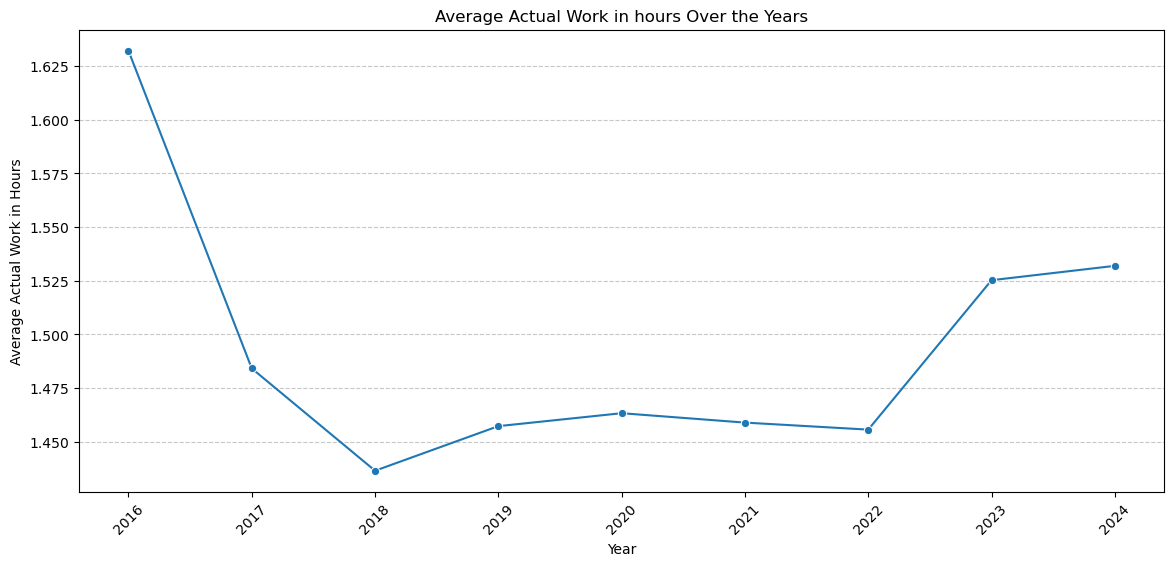

In [25]:
# Plotting a Line Plot with trend lines to show the average work time per year

# Ensure date columns are in datetime format
iwc_df_copy['EXECUTION_FINISH_DATE'] = pd.to_datetime(iwc_df_copy['EXECUTION_FINISH_DATE'])

# Convert actual work minutes to hours
iwc_df_copy['ACTUAL_WORK_HOURS'] = iwc_df_copy['ACTUAL_WORK_IN_MINUTES'] / 60  # Convert minutes to hours

# Extract year from the execution finish date
iwc_df_copy['YEAR'] = iwc_df_copy['EXECUTION_FINISH_DATE'].dt.year


# Plotting a Line Plot with trend lines to show the average work time per year
plt.figure(figsize=(14, 6))
sns.lineplot(data=iwc_df_copy, x='YEAR', y='ACTUAL_WORK_HOURS', ci=None, estimator='mean', marker='o')
plt.title('Average Actual Work in hours Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Actual Work in Hours')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

## 5. Data Cleaning and Data Manipulation

In [27]:
# Dropping all the rows with "Equipment_ID" as NaN.
cleaned_data = iwc_df_copy.dropna(subset=['EQUIPMENT_ID'])

In [28]:
# Imputing 'FUNCTIONAL_AREA_NODE_1_MODIFIED'

cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].value_counts()
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='MONACO']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'MONACO'),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'MONACO PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='MONZA']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'MONZA') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].isna()),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'MONZA PRODUCTION'
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'ROMA') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED']=='PRODUCTION'),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'ROMA PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='SILVERSTONE']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'SILVERSTONE') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].isna()),
       'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'SILVERSTONE PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='COTA']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'COTA'),
       'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'COTA PRODUCTION'

In [29]:
# Imputing 'FUNCTIONAL_AREA_NODE_2_MODIFIED'

cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].nunique()
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].value_counts()
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'AIR', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'AIR SYSTEM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CO2', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CO2 SYSTEM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BOTTLE', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BOTTLE LINE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CAN', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CAN LINE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'REFRIGERATION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'REFRIGERATION SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BLENDING', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BLENDING ROOM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CIP', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CIP SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'WATER', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'WATER TREATMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'FACILITIES', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'FACILITIES'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'WAREHOUSE', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'WAREHOUSE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'PRODUCTION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'PRODUCTION'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'QUALITY', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'QUALITY ASSURANCE EQUIPMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'SAFETY', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'SAFETY EQUIPMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BTL_PET', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BTL_PET_LINE '
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'RECYCLING', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'RECYCLING'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'PRD LINES', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'PRD LINES'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'STEAM', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'STEAM SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'SANITATION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'SANITATION SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BIB', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BIB LINE'

In [30]:
# Verifying Modified Data
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].nunique()
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].value_counts()

FUNCTIONAL_AREA_NODE_2_MODIFIED
CAN LINE                       103525
BOTTLE LINE                     87885
BTL_PET_LINE                    43989
AIR SYSTEM                       9366
WATER TREATMENT                  6631
BLENDING ROOM                    5274
REFRIGERATION SYSTEMS            4402
COMMON EQUIPMENT                 3069
RECYCLING                        2775
COOLER SERVICE HVAC              2699
CO2 SYSTEM                       2543
STEAM SYSTEMS                    2313
BIB LINE                         1197
OFFICES                           903
HEATING SYSTEMS                   805
PRD LINES                         773
FACILITIES                        711
NITROGEN SYSTEMS                  591
QUALITY ASSURANCE EQUIPMENT       503
SAFETY EQUIPMENT                  460
CIP SYSTEMS                       351
PRODUCTION                        332
SANITATION SYSTEMS                255
NEW PM PLAN                       211
WAREHOUSE                         196
GROUNDS           

In [31]:
# Funtional Location

cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300026806, 'FUNCTIONAL_LOC'] = 'G816-PRD-L15-L03-L130'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300045068, 'FUNCTIONAL_LOC'] = 'G811-PRD-L30-L03-L030'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300001115, 'FUNCTIONAL_LOC'] = 'G291-PRD-L30-L01-L070'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 400002825, 'FUNCTIONAL_LOC'] = 'G261-PRD-P25-XXX'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 400002842, 'FUNCTIONAL_LOC'] = 'G261-PRD-P42-XXX'

In [32]:
# Funcational_AREA_NODE_2_MODIFIED

# Group by relevant columns
grouped = cleaned_data.groupby(
    ['EQUIPMENT_ID', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'FUNCTIONAL_AREA_NODE_1_MODIFIED']
)['FUNCTIONAL_AREA_NODE_2_MODIFIED']

# Fill NaN values within each group using ffill and bfill
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1967205021.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED']))
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1967205021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2

In [33]:
#FUNCTIONAL_AREA_NODE_2_MODIFIED


condition = (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna()) | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')
check_condition = condition & (cleaned_data['ORDER_DESCRIPTION'].str.contains(r'\b(?:check|daily|utility|utilities|meetings|meeting|Line Walk|cleaing)\b', case=False, na=False))

# Fill FUNCTIONAL_AREA_NODE_2_MODIFIED with 'Routine Check' where the condition is met
cleaned_data.loc[check_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'Routine Check'


# Adding specific match for 'lube' and 'oil' using word boundaries
lube_oil_condition = condition & (cleaned_data['ORDER_DESCRIPTION'].str.contains(r'\b(?:lube|oil)\b', case=False, na=False))

# Fill FUNCTIONAL_AREA_NODE_2_MODIFIED with 'Lubrication' where the condition is met
cleaned_data.loc[lube_oil_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'LUBRICATION'



# Can Line Update
# FUNCTIONAL_AREA_NODE_2_MODIFIED
null_or_blank_condition = cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')

condition = (cleaned_data['ORDER_DESCRIPTION'].str.contains('CAN', case=False, na=False))
a=condition&null_or_blank_condition
cleaned_data.loc[a, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CAN LINE'


condition2 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('CNG', case=False, na=False))

b=condition2&null_or_blank_condition

cleaned_data.loc[b, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'REFRIGERATION SYSTEMS'



condition3 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('Tank', case=False, na=False))

# Additional condition to check for 'COTA' in FUNCTIONAL_AREA_NODE_1_MODIFIED
cota_condition = cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].str.contains('COTA', case=False, na=False)

# Combine both conditions
combined_condition = condition3 & cota_condition & null_or_blank_condition

cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'WATER TREATMENT'




condition4 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('PUMP', case=False, na=False))

# Condition to check if FUNCTIONAL_AREA_NODE_2_MODIFIED is null or blank

combined_condition = condition4 & cota_condition & null_or_blank_condition

# Update FUNCTIONAL_AREA_NODE_2_MODIFIED where all conditions are met
cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BLENDING ROOM'

condition6 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('SYRUP', case=False, na=False))
combined_condition = condition6  & null_or_blank_condition
cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BLENDING ROOM'




monaco_condition = cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].str.contains('MONACO', case=False, na=False)

condition5 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('DEPALLETIZER', case=False, na=False))

# Condition to check if FUNCTIONAL_AREA_NODE_2_MODIFIED is null or blank

# Combine all conditions
combined_condition = condition5 & monaco_condition & null_or_blank_condition

# Update FUNCTIONAL_AREA_NODE_2_MODIFIED where all conditions are met
cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CAN LINE'



condition7 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('SILO', case=False, na=False))
combined_condition = condition7  & null_or_blank_condition
cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BTL_PET_LINE'



condition8 = (cleaned_data['ORDER_DESCRIPTION'].str.contains('Bastian', case=False, na=False))
combined_condition = condition8  & null_or_blank_condition
cleaned_data.loc[combined_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'AIR SYSTEM'


# Additional condition for "syrup" and "room" both in the ORDER_DESCRIPTION
syrup_room_condition = condition & (cleaned_data['ORDER_DESCRIPTION'].str.contains(r'\bsyrup\b', case=False, na=False)) & (cleaned_data['ORDER_DESCRIPTION'].str.contains(r'\broom\b', case=False, na=False))

# Fill FUNCTIONAL_AREA_NODE_2_MODIFIED with 'BLENDING ROOM' where 'syrup' and 'room' are both in the ORDER_DESCRIPTION
cleaned_data.loc[syrup_room_condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BLENDING ROOM'

# Grouping by EQUIPMENT_ID and counting the number of N/A or blank values in FUNCTIONAL_AREA_NODE_2_MODIFIED
na_blank_counts = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]
equipment_na_counts = na_blank_counts.groupby('EQUIPMENT_ID').size().reset_index(name='na_blank_count')

# Sorting the result to find the EQUIPMENT_ID with the most N/A or blank values
equipment_na_counts_sorted = equipment_na_counts.sort_values(by='na_blank_count', ascending=False)

# Displaying the top 5 EQUIPMENT_IDs with the most N/A or blank values
equipment_na_counts_sorted.head()

,EQUIPMENT_ID,na_blank_count
38,300017654.0,1587
131,300224439.0,1202
136,300239802.0,187
46,300026992.0,79
125,300045283.0,68


In [34]:
# Step 1: Find rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is not null or blank, to use for matching
non_null_functional_area = cleaned_data[~(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == ''))]

# Create a mapping of FUNCTIONAL_LOC to FUNCTIONAL_AREA_NODE_2_MODIFIED from non-null rows
functional_loc_map = dict(zip(non_null_functional_area['FUNCTIONAL_LOC'], non_null_functional_area['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

# Step 2: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is null or blank and FUNCTIONAL_LOC exists
null_functional_area = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

# Step 3: Check if FUNCTIONAL_LOC exists in the mapping (before filling)
preview_fill = null_functional_area[null_functional_area['FUNCTIONAL_LOC'].isin(functional_loc_map.keys())]

# Step 4: Preview the results before filling
preview_fill[['FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED']].head()


# Step 4: Provide unique FUNCTIONAL_LOC and FUNCTIONAL_AREA_NODE_2_MODIFIED pairs before filling
unique_preview_fill = preview_fill[['FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED']].drop_duplicates()

# Display unique FUNCTIONAL_LOC and FUNCTIONAL_AREA_NODE_2_MODIFIED pairs
print(unique_preview_fill)


# Step 1: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is N/A or blank
na_or_blank_functional_area = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

# Step 2: Extract ORDER_DESCRIPTION as a list of sentences from these rows
blank_sentences = na_or_blank_functional_area['ORDER_DESCRIPTION'].dropna().tolist()

# Step 3: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is not blank (filled)
filled_functional_area = cleaned_data[~(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna()) & (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() != '')]

# Step 4: Create a mapping of ORDER_DESCRIPTION to FUNCTIONAL_AREA_NODE_2_MODIFIED from filled rows
description_to_functional_area_map = dict(zip(filled_functional_area['ORDER_DESCRIPTION'], filled_functional_area['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

# Step 5: Compare sentences and infer FUNCTIONAL_AREA_NODE_2_MODIFIED for blank rows
for sentence in blank_sentences:
    if sentence in description_to_functional_area_map:
        # Find matching sentence and assign the corresponding FUNCTIONAL_AREA_NODE_2_MODIFIED
        cleaned_data.loc[cleaned_data['ORDER_DESCRIPTION'] == sentence, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = description_to_functional_area_map[sentence]

# Step 6: Verify changes
updated_data = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

                     FUNCTIONAL_LOC FUNCTIONAL_AREA_NODE_2_MODIFIED
41298                      G812-PRD                             NaN
42057                      G816-PRD                             NaN
42218    G811-PRD-L30-L03-L030-0020                             NaN
43248         G811-PRD-L30-L02-L060                             NaN
43267                      G221-PRD                             NaN
45212         G811-PRD-L35-L04-L080                             NaN
45589              G291-PRD-L30-S01                             NaN
46613         G811-PRD-L30-L03-L060                             NaN
47890                      G811-PRD                             NaN
48133         G291-PRD-P80-XXX-S190                             NaN
48139                      G291-PRD                             NaN
85831         G816-PRD-L15-L03-L130                             NaN
86939         G811-PRD-P80-XXX-S210                             NaN
90782         G291-PRD-P40-XXX-S020             

In [35]:
# VALID FROM, VALID TO, START UP DATE
date_columns = ['EQUIP_VALID_FROM', 'EQUIP_START_UP_DATE']  # Add other date columns as needed

# Convert each column to datetime format
for column in date_columns:
    cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')

cleaned_data['EQUIP_VALID_TO'] = pd.to_datetime('15-12-2024', format='%d-%m-%Y')

# Fill null or N/A values in the 'EQUIP_VALID_FROM' column with '12/10/2024'
cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')  # Ensure it's in datetime format
cleaned_data['EQUIP_VALID_FROM'].fillna(pd.to_datetime('12/10/2024', format='%d/%m/%Y'), inplace=True)

# Verify the changes by checking the first few rows
cleaned_data['EQUIP_VALID_FROM'].head()

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\389502772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\389502772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\389502772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

0   2020-02-10
1   2020-02-10
2   2020-02-10
3   2020-02-10
4   2023-12-11
Name: EQUIP_VALID_FROM, dtype: datetime64[ns]

In [36]:
# Ensure both columns are in datetime format
cleaned_data['EQUIP_START_UP_DATE'] = pd.to_datetime(cleaned_data['EQUIP_START_UP_DATE'], errors='coerce')
cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')

# Calculate the difference in days between EQUIP_VALID_FROM and EQUIP_START_UP_DATE
date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

# Identify rows where the difference is negative
negative_diff_condition = date_diff < 0

# Update EQUIP_START_UP_DATE to match EQUIP_VALID_FROM where the difference is negative
cleaned_data.loc[negative_diff_condition, 'EQUIP_START_UP_DATE'] = cleaned_data.loc[negative_diff_condition, 'EQUIP_VALID_FROM']

# Verify the changes by checking the first few rows where EQUIP_START_UP_DATE was updated
cleaned_data[negative_diff_condition][['EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM']].head()

# Step 1: Calculate the difference in days between EQUIP_START_UP_DATE and EQUIP_VALID_FROM
date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

# Step 2: Find the mean of the differences where both dates are available
mean_diff_days = date_diff.mean()

# Print the mean difference
print(f'Mean difference in days: {mean_diff_days}')

# Step 3: Fill missing values in EQUIP_START_UP_DATE using the mean difference (without time component)
condition = cleaned_data['EQUIP_START_UP_DATE'].isna()  # Identify rows where EQUIP_START_UP_DATE is NaN
cleaned_data.loc[condition, 'EQUIP_START_UP_DATE'] = (cleaned_data['EQUIP_VALID_FROM'] - pd.to_timedelta(mean_diff_days, unit='days')).dt.date

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2694148045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['EQUIP_START_UP_DATE'] = pd.to_datetime(cleaned_data['EQUIP_START_UP_DATE'], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2694148045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')


Mean difference in days: 631.1467015746347


In [37]:
# FOR FUNCTIONAL 5

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['EQUIPMENT_DESC'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes
cleaned_data[['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'EQUIPMENT_DESC']].head()

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['FUNCTIONAL_AREA_NODE_5_MODIFIED'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes
# Case 1: If FUNCTIONAL_AREA_NODE_5_MODIFIED is not null but EQUIPMENT_DESC is null, fill EQUIPMENT_DESC with FUNCTIONAL_AREA_NODE_5_MODIFIED
condition1 = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].notna() & cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition1, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition1, 'FUNCTIONAL_AREA_NODE_5_MODIFIED']

# Case 2: If EQUIPMENT_DESC is not null but FUNCTIONAL_AREA_NODE_5_MODIFIED is null, fill FUNCTIONAL_AREA_NODE_5_MODIFIED with EQUIPMENT_DESC
condition2 = cleaned_data['EQUIPMENT_DESC'].notna() & cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition2, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition2, 'EQUIPMENT_DESC']

# Verify the changes
cleaned_data[['FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_DESC']].head()

,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_DESC
0,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
1,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
2,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
3,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
4,TANK_STL_STOR_AIR,TANK_STL_STOR_AIR


In [38]:
# ORDER DESCRIPTION

cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['EQUIPMENT_DESC'])
cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'])

remaining_missing_order_desc = cleaned_data['ORDER_DESCRIPTION'].isnull().sum()
remaining_missing_order_desc

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1522536054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['EQUIPMENT_DESC'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1522536054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'])


3

In [39]:
# Removing Columns

# Dropping the specified columns
cleaned_data = cleaned_data.drop(['MAINTENANCE_PLAN', 'MAINTENANCE_ITEM','ACTUAL_WORK_HOURS','YEAR'], axis=1)

# Verify the columns have been dropped
cleaned_data.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,...,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,ACTUAL_WORK_IN_HOURS
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),...,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,6.5
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,Unplanned,LINE 3 CONVEYOR AT CAN CODER,...,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,7.0
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,Unplanned,BROKEN CONVEYOR RAIL,...,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,0.5
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,Unplanned,LINE 3 CONVEYOR,...,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,1.0
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,Unplanned,REPLACED SONIC AIR BLOWER BELT,...,NaN,NaN,TANK_STL_STOR_AIR,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,2024-12-15,2.0


In [40]:
# CLeaning remaining null values by putting NA to it

# Filling all null values in categorical columns with "Others"
cleaned_data.fillna('Others', inplace=True)

# Verify that null values are filled
print(cleaned_data.isnull().sum())

ORDER_ID                           0
PLANT_ID                           0
PRODUCTION_LOCATION                0
EXECUTION_START_DATE               0
EXECUTION_FINISH_DATE              0
ACTUAL_START_TIME                  0
ACTUAL_FINISH_TIME                 0
ACTUAL_WORK_IN_MINUTES             0
MAINTENANCE_ACTIVITY_TYPE          0
ORDER_DESCRIPTION                  0
MAINTENANCE_TYPE_DESCRIPTION       0
FUNCTIONAL_LOC                     0
FUNCTIONAL_AREA_NODE_1_MODIFIED    0
FUNCTIONAL_AREA_NODE_2_MODIFIED    0
FUNCTIONAL_AREA_NODE_3_MODIFIED    0
FUNCTIONAL_AREA_NODE_4_MODIFIED    0
FUNCTIONAL_AREA_NODE_5_MODIFIED    0
EQUIPMENT_ID                       0
EQUIPMENT_DESC                     0
EQUIP_CAT_DESC                     0
EQUIP_START_UP_DATE                0
EQUIP_VALID_FROM                   0
EQUIP_VALID_TO                     0
ACTUAL_WORK_IN_HOURS               0
dtype: int64


## 6. Feature Engineering

In [42]:
# Dropping all the rows with "Equipment_ID" as NaN.
cleaned_data = iwc_df_copy.dropna(subset=['EQUIPMENT_ID'])

In [43]:
# Imputing 'FUNCTIONAL_AREA_NODE_1_MODIFIED'

cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].value_counts()
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='MONACO']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'MONACO'),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'MONACO PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='MONZA']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'MONZA') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].isna()),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'MONZA PRODUCTION'
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'ROMA') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED']=='PRODUCTION'),'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'ROMA PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='SILVERSTONE']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'SILVERSTONE') & (cleaned_data['FUNCTIONAL_AREA_NODE_1_MODIFIED'].isna()),
       'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'SILVERSTONE PRODUCTION'
cleaned_data.loc[cleaned_data['PRODUCTION_LOCATION']=='COTA']['FUNCTIONAL_AREA_NODE_1_MODIFIED'].unique()
cleaned_data.loc[(cleaned_data['PRODUCTION_LOCATION'] == 'COTA'),
       'FUNCTIONAL_AREA_NODE_1_MODIFIED'] = 'COTA PRODUCTION'

In [44]:
# Imputing 'FUNCTIONAL_AREA_NODE_2_MODIFIED'

cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].nunique()
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].value_counts()
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'AIR', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'AIR SYSTEM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CO2', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CO2 SYSTEM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BOTTLE', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BOTTLE LINE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CAN', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CAN LINE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'REFRIGERATION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'REFRIGERATION SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BLENDING', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BLENDING ROOM'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'CIP', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'CIP SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'WATER', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'WATER TREATMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'FACILITIES', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'FACILITIES'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'WAREHOUSE', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'WAREHOUSE'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'PRODUCTION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'PRODUCTION'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'QUALITY', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'QUALITY ASSURANCE EQUIPMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'SAFETY', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'SAFETY EQUIPMENT'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BTL_PET', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BTL_PET_LINE '
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'RECYCLING', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'RECYCLING'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'PRD LINES', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'PRD LINES'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'STEAM', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'STEAM SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'SANITATION', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'SANITATION SYSTEMS'
cleaned_data.loc[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.contains(r'BIB', na=False), 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = 'BIB LINE'

In [45]:
# Funtional Plant Location

cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300026806, 'FUNCTIONAL_LOC'] = 'G816-PRD-L15-L03-L130'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300045068, 'FUNCTIONAL_LOC'] = 'G811-PRD-L30-L03-L030'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 300001115, 'FUNCTIONAL_LOC'] = 'G291-PRD-L30-L01-L070'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 400002825, 'FUNCTIONAL_LOC'] = 'G261-PRD-P25-XXX'
cleaned_data.loc[cleaned_data['EQUIPMENT_ID'] == 400002842, 'FUNCTIONAL_LOC'] = 'G261-PRD-P42-XXX'

In [46]:
# Functional_AREA_NODE_2_MODIFIED

# Group by relevant columns
grouped = cleaned_data.groupby(
    ['EQUIPMENT_ID', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'FUNCTIONAL_AREA_NODE_1_MODIFIED']
)['FUNCTIONAL_AREA_NODE_2_MODIFIED']

# Fill NaN values within each group using ffill and bfill
cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2952166276.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED']))
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2952166276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = (grouped.transform(lambda x: x.ffill().bfill()).combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_2

In [47]:
# Functional Area Node 4 and 5

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['EQUIPMENT_DESC'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes
cleaned_data[['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'EQUIPMENT_DESC']].head()

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['FUNCTIONAL_AREA_NODE_5_MODIFIED'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes
# Case 1: If FUNCTIONAL_AREA_NODE_5_MODIFIED is not null but EQUIPMENT_DESC is null, fill EQUIPMENT_DESC with FUNCTIONAL_AREA_NODE_5_MODIFIED
condition1 = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].notna() & cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition1, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition1, 'FUNCTIONAL_AREA_NODE_5_MODIFIED']

# Case 2: If EQUIPMENT_DESC is not null but FUNCTIONAL_AREA_NODE_5_MODIFIED is null, fill FUNCTIONAL_AREA_NODE_5_MODIFIED with EQUIPMENT_DESC
condition2 = cleaned_data['EQUIPMENT_DESC'].notna() & cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition2, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition2, 'EQUIPMENT_DESC']

# Verify the changes
cleaned_data[['FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_DESC']].head()

,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_DESC
0,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
1,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
2,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
3,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
4,TANK_STL_STOR_AIR,TANK_STL_STOR_AIR


In [48]:
# Step 1: Find rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is not null or blank, to use for matching
non_null_functional_area = cleaned_data[~(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == ''))]

# Create a mapping of FUNCTIONAL_LOC to FUNCTIONAL_AREA_NODE_2_MODIFIED from non-null rows
functional_loc_map = dict(zip(non_null_functional_area['FUNCTIONAL_LOC'], non_null_functional_area['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

# Step 2: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is null or blank and FUNCTIONAL_LOC exists
null_functional_area = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

# Step 3: Check if FUNCTIONAL_LOC exists in the mapping (before filling)
preview_fill = null_functional_area[null_functional_area['FUNCTIONAL_LOC'].isin(functional_loc_map.keys())]

# Step 4: Preview the results before filling
preview_fill[['FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED']].head()


# Step 4: Provide unique FUNCTIONAL_LOC and FUNCTIONAL_AREA_NODE_2_MODIFIED pairs before filling
unique_preview_fill = preview_fill[['FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED']].drop_duplicates()

# Display unique FUNCTIONAL_LOC and FUNCTIONAL_AREA_NODE_2_MODIFIED pairs
print(unique_preview_fill)


# Step 1: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is N/A or blank
na_or_blank_functional_area = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

# Step 2: Extract ORDER_DESCRIPTION as a list of sentences from these rows
blank_sentences = na_or_blank_functional_area['ORDER_DESCRIPTION'].dropna().tolist()

# Step 3: Filter rows where FUNCTIONAL_AREA_NODE_2_MODIFIED is not blank (filled)
filled_functional_area = cleaned_data[~(cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna()) & (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() != '')]

# Step 4: Create a mapping of ORDER_DESCRIPTION to FUNCTIONAL_AREA_NODE_2_MODIFIED from filled rows
description_to_functional_area_map = dict(zip(filled_functional_area['ORDER_DESCRIPTION'], filled_functional_area['FUNCTIONAL_AREA_NODE_2_MODIFIED']))

# Step 5: Compare sentences and infer FUNCTIONAL_AREA_NODE_2_MODIFIED for blank rows
for sentence in blank_sentences:
    if sentence in description_to_functional_area_map:
        # Find matching sentence and assign the corresponding FUNCTIONAL_AREA_NODE_2_MODIFIED
        cleaned_data.loc[cleaned_data['ORDER_DESCRIPTION'] == sentence, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = description_to_functional_area_map[sentence]

# Step 6: Verify changes
updated_data = cleaned_data[cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')]

                     FUNCTIONAL_LOC FUNCTIONAL_AREA_NODE_2_MODIFIED
41968                      G816-PRD                             NaN
42218    G811-PRD-L30-L03-L030-0020                             NaN
48133         G291-PRD-P80-XXX-S190                             NaN
48139                      G291-PRD                             NaN
85831         G816-PRD-L15-L03-L130                             NaN
90782         G291-PRD-P40-XXX-S020                             NaN
134323                     G999-SLC                             NaN
228688                 G291-PRD-P20                             NaN
315827   G811-PRD-L30-L03-L030-0023                             NaN
490193        G811-PRD-L30-L03-L030                             NaN
1106727       G291-PRD-L30-L01-L070                             NaN


In [49]:
# VALID FROM, VALID TO, START UP DATE

date_columns = ['EQUIP_VALID_FROM', 'EQUIP_START_UP_DATE']  # Add other date columns as needed

# Convert each column to datetime format
for column in date_columns:
    cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')

cleaned_data['EQUIP_VALID_TO'] = pd.to_datetime('15-12-2024', format='%d-%m-%Y')

# Fill null or N/A values in the 'EQUIP_VALID_FROM' column with '12/10/2024'
cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')  # Ensure it's in datetime format
cleaned_data['EQUIP_VALID_FROM'].fillna(pd.to_datetime('12/10/2024', format='%d/%m/%Y'), inplace=True)

# Verify the changes by checking the first few rows
cleaned_data['EQUIP_VALID_FROM'].head()

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\372789193.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\372789193.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\372789193.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

0   2020-02-10
1   2020-02-10
2   2020-02-10
3   2020-02-10
4   2023-12-11
Name: EQUIP_VALID_FROM, dtype: datetime64[ns]

In [50]:
# Ensure both columns are in datetime format
cleaned_data['EQUIP_START_UP_DATE'] = pd.to_datetime(cleaned_data['EQUIP_START_UP_DATE'], errors='coerce')
cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')

# Calculate the difference in days between EQUIP_VALID_FROM and EQUIP_START_UP_DATE
date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

# Identify rows where the difference is negative
negative_diff_condition = date_diff < 0

# Update EQUIP_START_UP_DATE to match EQUIP_VALID_FROM where the difference is negative
cleaned_data.loc[negative_diff_condition, 'EQUIP_START_UP_DATE'] = cleaned_data.loc[negative_diff_condition, 'EQUIP_VALID_FROM']

# Verify the changes by checking the first few rows where EQUIP_START_UP_DATE was updated
cleaned_data[negative_diff_condition][['EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM']].head()

# Step 1: Calculate the difference in days between EQUIP_START_UP_DATE and EQUIP_VALID_FROM
date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

date_diff = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days

# Step 2: Find the mean of the differences where both dates are available
mean_diff_days = date_diff.mean()

# Print the mean difference
print(f'Mean difference in days: {mean_diff_days}')

# Step 3: Fill missing values in EQUIP_START_UP_DATE using the mean difference (without time component)
condition = cleaned_data['EQUIP_START_UP_DATE'].isna()  # Identify rows where EQUIP_START_UP_DATE is NaN
cleaned_data.loc[condition, 'EQUIP_START_UP_DATE'] = (cleaned_data['EQUIP_VALID_FROM'] - pd.to_timedelta(mean_diff_days, unit='days')).dt.date

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2694148045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['EQUIP_START_UP_DATE'] = pd.to_datetime(cleaned_data['EQUIP_START_UP_DATE'], errors='coerce')
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\2694148045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')


Mean difference in days: 631.1467015746347


In [51]:
# For Functional Area Node 4 and 5

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['EQUIPMENT_DESC'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes
cleaned_data[['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'EQUIPMENT_DESC']].head()

# Step 1: Group by equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED and find the most frequent FUNCTIONAL_AREA_NODE_5_MODIFIED
grouped = cleaned_data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_4_MODIFIED'])['FUNCTIONAL_AREA_NODE_5_MODIFIED'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)

# Step 2: Create a dictionary to map equipment_id and FUNCTIONAL_AREA_NODE_4_MODIFIED to FUNCTIONAL_AREA_NODE_5_MODIFIED
mapping = grouped.to_dict()

# Step 3: Fill the missing values in FUNCTIONAL_AREA_NODE_5_MODIFIED based on the mapping
condition = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition].apply(
    lambda row: mapping.get((row['EQUIPMENT_ID'], row['FUNCTIONAL_AREA_NODE_4_MODIFIED'])), axis=1
)

# Verify the changes


# Case 1: If FUNCTIONAL_AREA_NODE_5_MODIFIED is not null but EQUIPMENT_DESC is null, fill EQUIPMENT_DESC with FUNCTIONAL_AREA_NODE_5_MODIFIED
condition1 = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].notna() & cleaned_data['EQUIPMENT_DESC'].isna()
cleaned_data.loc[condition1, 'EQUIPMENT_DESC'] = cleaned_data.loc[condition1, 'FUNCTIONAL_AREA_NODE_5_MODIFIED']

# Case 2: If EQUIPMENT_DESC is not null but FUNCTIONAL_AREA_NODE_5_MODIFIED is null, fill FUNCTIONAL_AREA_NODE_5_MODIFIED with EQUIPMENT_DESC
condition2 = cleaned_data['EQUIPMENT_DESC'].notna() & cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].isna()
cleaned_data.loc[condition2, 'FUNCTIONAL_AREA_NODE_5_MODIFIED'] = cleaned_data.loc[condition2, 'EQUIPMENT_DESC']

# Verify the changes
cleaned_data[['FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_DESC']].head()

,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_DESC
0,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
1,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
2,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
3,FULL CAN CONVEYOR,FULL CAN CONVEYOR (FC41B)
4,TANK_STL_STOR_AIR,TANK_STL_STOR_AIR


In [52]:
# Check for rows where FUNCTIONAL_AREA_NODE_5_MODIFIED is not null and EQUIPMENT_DESC is null
condition = cleaned_data['FUNCTIONAL_AREA_NODE_5_MODIFIED'].notna() & cleaned_data['EQUIPMENT_DESC'].isna()

# Count the number of such rows
count = condition.sum()

# Print the count
print(f"Number of rows where FUNCTIONAL_AREA_NODE_5_MODIFIED is not null but EQUIPMENT_DESC is null: {count}")

Number of rows where FUNCTIONAL_AREA_NODE_5_MODIFIED is not null but EQUIPMENT_DESC is null: 0


In [53]:
# ORDER DESCRIPTION

cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['EQUIPMENT_DESC'])
cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'])

remaining_missing_order_desc = cleaned_data['ORDER_DESCRIPTION'].isnull().sum()
remaining_missing_order_desc

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1522536054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['EQUIPMENT_DESC'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1522536054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['ORDER_DESCRIPTION'] = cleaned_data['ORDER_DESCRIPTION'].combine_first(cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'])


3

In [54]:
# Removing Columns

# Dropping the specified columns
cleaned_data = cleaned_data.drop(['MAINTENANCE_PLAN', 'MAINTENANCE_ITEM'], axis=1)

# Verify the columns have been dropped
cleaned_data.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,...,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,ACTUAL_WORK_IN_HOURS,ACTUAL_WORK_HOURS,YEAR
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),...,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,6.5,6.5,2024
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,Unplanned,LINE 3 CONVEYOR AT CAN CODER,...,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,7.0,7.0,2022
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,Unplanned,BROKEN CONVEYOR RAIL,...,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,0.5,0.5,2022
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,Unplanned,LINE 3 CONVEYOR,...,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-02-10,2020-02-10,2024-12-15,1.0,1.0,2022
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,Unplanned,REPLACED SONIC AIR BLOWER BELT,...,TANK_STL_STOR_AIR,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,2024-12-15,2.0,2.0,2023


In [55]:
# CLeaning remaining null values by replacing NAs with " Others" to it.

# Filling all null values in categorical columns with "Others"
cleaned_data.fillna('Others', inplace=True)

# Verify that null values are filled
print(cleaned_data.isnull().sum())

ORDER_ID                           0
PLANT_ID                           0
PRODUCTION_LOCATION                0
EXECUTION_START_DATE               0
EXECUTION_FINISH_DATE              0
ACTUAL_START_TIME                  0
ACTUAL_FINISH_TIME                 0
ACTUAL_WORK_IN_MINUTES             0
MAINTENANCE_ACTIVITY_TYPE          0
ORDER_DESCRIPTION                  0
MAINTENANCE_TYPE_DESCRIPTION       0
FUNCTIONAL_LOC                     0
FUNCTIONAL_AREA_NODE_1_MODIFIED    0
FUNCTIONAL_AREA_NODE_2_MODIFIED    0
FUNCTIONAL_AREA_NODE_3_MODIFIED    0
FUNCTIONAL_AREA_NODE_4_MODIFIED    0
FUNCTIONAL_AREA_NODE_5_MODIFIED    0
EQUIPMENT_ID                       0
EQUIPMENT_DESC                     0
EQUIP_CAT_DESC                     0
EQUIP_START_UP_DATE                0
EQUIP_VALID_FROM                   0
EQUIP_VALID_TO                     0
ACTUAL_WORK_IN_HOURS               0
ACTUAL_WORK_HOURS                  0
YEAR                               0
dtype: int64


In [56]:
# Functional Node 2

# Step 1: Define a condition for rows with missing FUNCTIONAL_AREA_NODE_2_MODIFIED
condition = (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna()) | (cleaned_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.strip() == '')

# Step 2: Separate rows with and without missing values in FUNCTIONAL_AREA_NODE_2_MODIFIED
data_with_values = cleaned_data[~condition]
data_missing_values = cleaned_data[condition]

# Confirm if there are any rows in each subset
if len(data_with_values) == 0 or len(data_missing_values) == 0:
    print("No rows to process for one of the subsets.")
else:
    # Step 3: Vectorize ORDER_DESCRIPTION using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cleaned_data['ORDER_DESCRIPTION'].fillna(''))

    # Step 4: Find the TF-IDF vectors for rows with and without missing FUNCTIONAL_AREA_NODE_2_MODIFIED
    tfidf_with_values = tfidf_matrix[~condition]
    tfidf_missing_values = tfidf_matrix[condition]

    # Step 5: Calculate cosine similarity only if valid data is available
    if tfidf_missing_values.shape[0] > 0 and tfidf_with_values.shape[0] > 0:
        similarity_matrix = cosine_similarity(tfidf_missing_values, tfidf_with_values)

        # Step 6: For each missing row, find the most similar row with a known FUNCTIONAL_AREA_NODE_2_MODIFIED
        most_similar_indices = np.argmax(similarity_matrix, axis=1)
        predicted_values = data_with_values.iloc[most_similar_indices]['FUNCTIONAL_AREA_NODE_2_MODIFIED'].values

        # Step 7: Fill the missing FUNCTIONAL_AREA_NODE_2_MODIFIED values
        cleaned_data.loc[condition, 'FUNCTIONAL_AREA_NODE_2_MODIFIED'] = predicted_values

        # Optional: Verify the changes by checking a few rows where values were filled
        filled_rows = cleaned_data[condition][['ORDER_DESCRIPTION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED']]
        print(filled_rows.head())

    else:
        print("Insufficient data for similarity comparison.")


No rows to process for one of the subsets.


In [57]:
# Functional Node 3

# Define a condition for rows with missing FUNCTIONAL_AREA_NODE_3_MODIFIED
condition_3 = (cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'].isna()) | (cleaned_data['FUNCTIONAL_AREA_NODE_3_MODIFIED'].str.strip() == '')

# Check if there are any rows to process
if condition_3.sum() > 0:
    # Separate rows with and without missing values in FUNCTIONAL_AREA_NODE_3_MODIFIED
    data_with_values_3 = cleaned_data[~condition_3]
    data_missing_values_3 = cleaned_data[condition_3]

    # Vectorize ORDER_DESCRIPTION using TF-IDF
    vectorizer_3 = TfidfVectorizer(stop_words='english')
    tfidf_matrix_3 = vectorizer_3.fit_transform(cleaned_data['ORDER_DESCRIPTION'].fillna(''))

    # Apply NearestNeighbors to find the closest non-missing FUNCTIONAL_AREA_NODE_3_MODIFIED values
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(tfidf_matrix_3[~condition_3])
    distances, indices = nbrs.kneighbors(tfidf_matrix_3[condition_3])

    # Fill the missing values based on nearest neighbors
    predicted_values_3 = data_with_values_3.iloc[indices.flatten()]['FUNCTIONAL_AREA_NODE_3_MODIFIED'].values
    cleaned_data.loc[condition_3, 'FUNCTIONAL_AREA_NODE_3_MODIFIED'] = predicted_values_3

    # Verify the changes
    filled_rows_3 = cleaned_data[condition_3][['ORDER_DESCRIPTION', 'FUNCTIONAL_AREA_NODE_3_MODIFIED']]
    print(filled_rows_3.head())
else:
    print("No missing values in FUNCTIONAL_AREA_NODE_3_MODIFIED.")

No missing values in FUNCTIONAL_AREA_NODE_3_MODIFIED.


In [58]:
# List of columns to remove
columns_to_remove = ['FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_DESC']

# Drop the columns
cleaned_data = cleaned_data.drop(columns=columns_to_remove)

# Verify that the columns are removed
print(cleaned_data.head())

    ORDER_ID PLANT_ID PRODUCTION_LOCATION EXECUTION_START_DATE  \
0  705642457     G812                ROMA           2024-05-04   
1  704191697     G812                ROMA           2022-09-13   
2  704466547     G812                ROMA           2022-12-21   
3  703834477     G812                ROMA           2022-07-04   
4  704661125     G291               MONZA           2023-03-15   

  EXECUTION_FINISH_DATE ACTUAL_START_TIME ACTUAL_FINISH_TIME  \
0            2024-05-12      06:00:00.000       23:04:08.000   
1            2022-09-13      06:00:00.000       17:17:24.000   
2            2022-12-21      07:00:00.000       07:00:00.000   
3            2022-07-04      06:00:00.000       06:00:00.000   
4            2023-03-15      07:00:00.000       07:00:00.000   

   ACTUAL_WORK_IN_MINUTES MAINTENANCE_ACTIVITY_TYPE  \
0                   390.0                 Unplanned   
1                   420.0                 Unplanned   
2                    30.0                 Unplanned  

In [59]:
# Ensure that EQUIP_START_UP_DATE, EQUIP_VALID_FROM, and EQUIP_VALID_TO are in datetime format

cleaned_data['EQUIP_START_UP_DATE'] = pd.to_datetime(cleaned_data['EQUIP_START_UP_DATE'], errors='coerce')
cleaned_data['EQUIP_VALID_FROM'] = pd.to_datetime(cleaned_data['EQUIP_VALID_FROM'], errors='coerce')
cleaned_data['EQUIP_VALID_TO'] = pd.to_datetime(cleaned_data['EQUIP_VALID_TO'], errors='coerce')

cleaned_data['TIME_TO_FIRST_USE'] = (cleaned_data['EQUIP_VALID_FROM'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days
cleaned_data['TOTAL_LIFESPAN'] = (cleaned_data['EQUIP_VALID_TO'] - cleaned_data['EQUIP_START_UP_DATE']).dt.days
cleaned_data['USABLE_DURATION'] = (cleaned_data['EQUIP_VALID_TO'] - cleaned_data['EQUIP_VALID_FROM']).dt.days
cleaned_data['TIME_USED_TO_LIFESPAN_RATIO'] = cleaned_data['ACTUAL_WORK_IN_MINUTES'] / (cleaned_data['TOTAL_LIFESPAN'] * 1440)  # where 1440 is minutes in a day


### Calculation of Frequency Machine Breakdowm

In [61]:
# Step 1: Calculate maintenance frequency per EQUIPMENT_ID
maintenance_frequency = cleaned_data['EQUIPMENT_ID'].value_counts()

# Step 2: Map the frequency count to a new column in the original dataset
cleaned_data['MAINTENANCE_FREQUENCY'] = cleaned_data['EQUIPMENT_ID'].map(maintenance_frequency)
mean_maintenance_duration = cleaned_data.groupby('EQUIPMENT_ID')['ACTUAL_WORK_IN_MINUTES'].transform('mean')

cleaned_data['MAINTENANCE_DURATION_DEVIATION'] = cleaned_data['ACTUAL_WORK_IN_MINUTES'] - mean_maintenance_duration

In [62]:
# Ensure that EXECUTION_START_DATE is in datetime format
cleaned_data['EXECUTION_START_DATE'] = pd.to_datetime(cleaned_data['EXECUTION_START_DATE'], errors='coerce')

# Extract month, quarter, and year from EXECUTION_START_DATE
cleaned_data['MAINTENANCE_MONTH'] = cleaned_data['EXECUTION_START_DATE'].dt.month
cleaned_data['MAINTENANCE_QUARTER'] = cleaned_data['EXECUTION_START_DATE'].dt.quarter
cleaned_data['MAINTENANCE_YEAR'] = cleaned_data['EXECUTION_START_DATE'].dt.year

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the relevant columns and add them as new columns
cleaned_data['NORM_TIME_USED_TO_LIFESPAN_RATIO'] = scaler.fit_transform(cleaned_data[['TIME_USED_TO_LIFESPAN_RATIO']])
cleaned_data['NORM_MAINTENANCE_FREQUENCY'] = scaler.fit_transform(cleaned_data[['MAINTENANCE_FREQUENCY']])
cleaned_data['NORM_MAINTENANCE_DURATION_DEVIATION'] = scaler.fit_transform(cleaned_data[['MAINTENANCE_DURATION_DEVIATION']])

# Calculate the Failure Risk Score
cleaned_data['FAILURE_RISK_SCORE'] = (
    (cleaned_data['NORM_TIME_USED_TO_LIFESPAN_RATIO'] + cleaned_data['NORM_MAINTENANCE_FREQUENCY']) / 2
) + cleaned_data['NORM_MAINTENANCE_DURATION_DEVIATION']

# Display the first few rows to verify
cleaned_data[['TIME_USED_TO_LIFESPAN_RATIO', 'MAINTENANCE_FREQUENCY', 'MAINTENANCE_DURATION_DEVIATION', 
              'FAILURE_RISK_SCORE']].head()


,TIME_USED_TO_LIFESPAN_RATIO,MAINTENANCE_FREQUENCY,MAINTENANCE_DURATION_DEVIATION,FAILURE_RISK_SCORE
0,0.000153,4,165.0,0.027168
1,0.000165,4,195.0,0.027496
2,0.000012,4,-195.0,0.023233
3,0.000024,4,-165.0,0.023561
4,0.000029,3,-86.0,0.024197


In [64]:
low_risk_threshold = cleaned_data['FAILURE_RISK_SCORE'].quantile(0.50)  # Median
medium_risk_threshold = cleaned_data['FAILURE_RISK_SCORE'].quantile(0.90)  # 90th percentile
cleaned_data['Risk_Level'] = pd.cut(
    cleaned_data['FAILURE_RISK_SCORE'],
    bins=[-float('inf'), low_risk_threshold, medium_risk_threshold, float('inf')],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)


# Display the data types of each column
print(cleaned_data.dtypes)


ORDER_ID                                        int64
PLANT_ID                                       object
PRODUCTION_LOCATION                            object
EXECUTION_START_DATE                   datetime64[ns]
EXECUTION_FINISH_DATE                  datetime64[ns]
ACTUAL_START_TIME                              object
ACTUAL_FINISH_TIME                             object
ACTUAL_WORK_IN_MINUTES                        float64
MAINTENANCE_ACTIVITY_TYPE                      object
ORDER_DESCRIPTION                              object
MAINTENANCE_TYPE_DESCRIPTION                   object
FUNCTIONAL_LOC                                 object
FUNCTIONAL_AREA_NODE_1_MODIFIED                object
FUNCTIONAL_AREA_NODE_2_MODIFIED                object
FUNCTIONAL_AREA_NODE_3_MODIFIED                object
FUNCTIONAL_AREA_NODE_4_MODIFIED                object
EQUIPMENT_ID                                  float64
EQUIP_CAT_DESC                                 object
EQUIP_START_UP_DATE         

In [65]:
# Exclude 'ORDER_DESCRIPTION' and convert remaining object columns to category
columns_to_convert = cleaned_data.select_dtypes(include=['object']).columns
columns_to_convert = columns_to_convert.drop('ORDER_DESCRIPTION')


from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label Encoding for 'Risk_Level' if not done already
label_encoder = LabelEncoder()
cleaned_data['Risk_Level'] = label_encoder.fit_transform(cleaned_data['Risk_Level'])

# Convert each selected column to category type
for column in columns_to_convert:
    cleaned_data[column] = cleaned_data[column].astype('category')
    
    
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Columns to label encode
label_encode_cols = ['PLANT_ID', 'PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 
                     'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_AREA_NODE_1_MODIFIED','FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 
              'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED']

# Apply label encoding to each specified column
for col in label_encode_cols:
    cleaned_data[col] = label_encoder.fit_transform(cleaned_data[col])

# Verify changes
print(cleaned_data[label_encode_cols].head())


# Verify the conversion
print(cleaned_data.dtypes)


   PLANT_ID  PRODUCTION_LOCATION  MAINTENANCE_ACTIVITY_TYPE  \
0         4                    3                          1   
1         4                    3                          1   
2         4                    3                          1   
3         4                    3                          1   
4         2                    2                          1   

   MAINTENANCE_TYPE_DESCRIPTION  FUNCTIONAL_AREA_NODE_1_MODIFIED  \
0                             3                                5   
1                             3                                5   
2                             3                                5   
3                             3                                5   
4                             3                                4   

   FUNCTIONAL_LOC  FUNCTIONAL_AREA_NODE_2_MODIFIED  \
0             536                                5   
1             536                                5   
2             536                                5

In [66]:
# Making sure that all datatypes are in place.

date_columns = ['EQUIP_VALID_FROM', 'EQUIP_START_UP_DATE','EXECUTION_START_DATE','EXECUTION_FINISH_DATE','EQUIP_VALID_TO']  # Add other date columns as needed

for column in date_columns:
    cleaned_data[column] = pd.to_datetime(cleaned_data[column], errors='coerce')


#### Predicting and Filtering Next Maintenance Schedules with Risk and Performance Data Integration

In [68]:
import pandas as pd

data = cleaned_data
# Ensure your maintenance date column is in datetime format
data['MAINTENANCE_DATE'] = pd.to_datetime(data['EXECUTION_START_DATE'])

# Sort the data by EQUIPMENT_ID, FUNCTIONAL_AREA_NODE_3_MODIFIED, and MAINTENANCE_DATE to get consecutive maintenance events
data = data.sort_values(by=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'MAINTENANCE_DATE'])

# Calculate the difference in days between consecutive maintenance events for each machine and functional area node
data['MAINTENANCE_INTERVAL'] = data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'])['MAINTENANCE_DATE'].diff().dt.days

# Drop rows where the interval is NaN (first maintenance event for each machine and functional area node)
data = data.dropna(subset=['MAINTENANCE_INTERVAL'])

# Calculate average maintenance interval for each machine and functional area node
avg_intervals = data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'])['MAINTENANCE_INTERVAL'].mean().reset_index()
avg_intervals.columns = ['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'AVG_MAINTENANCE_INTERVAL']

# Get the latest maintenance date for each machine and functional area node
latest_maintenance = data.groupby(['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'])['MAINTENANCE_DATE'].max().reset_index()

# Merge average intervals with the latest maintenance dates
next_maintenance = pd.merge(latest_maintenance, avg_intervals, on=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'])

# Project the next 5 maintenance dates for each machine and functional area node
for i in range(1, 6):
    next_maintenance[f'PREDICTED_NEXT_MAINTENANCE_DATE_{i}'] = next_maintenance['MAINTENANCE_DATE'] + pd.to_timedelta(i * next_maintenance['AVG_MAINTENANCE_INTERVAL'], unit='D')

# Filter rows where at least one predicted maintenance date is after 11/11/2024
filter_date = pd.to_datetime('2024-11-11')
next_maintenance_filtered = next_maintenance[
    (next_maintenance['PREDICTED_NEXT_MAINTENANCE_DATE_1'] > filter_date) | 
    (next_maintenance['PREDICTED_NEXT_MAINTENANCE_DATE_2'] > filter_date) | 
    (next_maintenance['PREDICTED_NEXT_MAINTENANCE_DATE_3'] > filter_date) | 
    (next_maintenance['PREDICTED_NEXT_MAINTENANCE_DATE_4'] > filter_date) | 
    (next_maintenance['PREDICTED_NEXT_MAINTENANCE_DATE_5'] > filter_date)
]

# Select the columns you want to include from the original data
additional_columns = ['PLANT_ID', 'PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_1_MODIFIED', 
                      'FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 
                      'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'ACTUAL_WORK_IN_MINUTES', 'Risk_Level']

# Ensure columns are the same data type before merging
next_maintenance_filtered['EQUIPMENT_ID'] = next_maintenance_filtered['EQUIPMENT_ID'].astype(data['EQUIPMENT_ID'].dtype)
next_maintenance_filtered['FUNCTIONAL_AREA_NODE_3_MODIFIED'] = next_maintenance_filtered['FUNCTIONAL_AREA_NODE_3_MODIFIED'].astype(data['FUNCTIONAL_AREA_NODE_3_MODIFIED'].dtype)

# Drop duplicates in the additional data to ensure uniqueness
data_additional = data[['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'] + additional_columns].drop_duplicates()

# Merge the filtered maintenance schedule with additional columns
next_maintenance_merged = next_maintenance_filtered.merge(data_additional, on=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'], how='left')

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1557384866.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_maintenance_filtered['EQUIPMENT_ID'] = next_maintenance_filtered['EQUIPMENT_ID'].astype(data['EQUIPMENT_ID'].dtype)
C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1557384866.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_maintenance_filtered['FUNCTIONAL_AREA_NODE_3_MODIFIED'] = next_maintenance_filtered['FUNCTIONAL_AREA_NODE_3_MODIFIED'].astype(data['FUNCTIONAL_AREA_NODE_3_MOD

In [69]:
next_maintenance_unique = next_maintenance_merged.drop_duplicates(subset=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED'])

# Convert the PREDICTED_NEXT_MAINTENANCE_DATE columns to date format only
date_columns = [f'PREDICTED_NEXT_MAINTENANCE_DATE_{i}' for i in range(1, 6)]

for col in date_columns:
    next_maintenance_unique[col] = next_maintenance_unique[col].dt.date  # Convert to date only

# Define columns to display
display_columns = ['PRODUCTION_LOCATION', 'EQUIPMENT_ID', 
     'FUNCTIONAL_AREA_NODE_1_MODIFIED', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 
     'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 
     'Risk_Level', 'MAINTENANCE_DATE'] + date_columns

# Display the unique results with the additional columns and predicted dates
print("Unique Predicted Next Maintenance Dates with Additional Columns (After 11/11/2024):\n", 
      next_maintenance_unique[display_columns])


Unique Predicted Next Maintenance Dates with Additional Columns (After 11/11/2024):
        PRODUCTION_LOCATION  EQUIPMENT_ID  FUNCTIONAL_AREA_NODE_1_MODIFIED  \
0                        3   200130411.0                                2   
2                        2   300001000.0                                4   
3                        2   300001005.0                                4   
13                       2   300001007.0                                4   
27                       2   300001010.0                                4   
...                    ...           ...                              ...   
13007                    0   400017400.0                                1   
13008                    1   400021000.0                                3   
13009                    0   400022400.0                                1   
13011                    0   400027400.0                                1   
13018                    5   400028001.0                            

C:\Users\nishi\AppData\Local\Temp\ipykernel_17780\1081469682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_maintenance_unique[col] = next_maintenance_unique[col].dt.date  # Convert to date only


In [70]:
# High-Risk Maintenance Predictions

# Define the high-risk level (replace with the actual value that represents "High Risk" in your data)
high_risk_value = "High Risk"  # or use the appropriate numerical value if coded numerically

# Filter for only high-risk entries
high_risk_maintenance = next_maintenance_unique[next_maintenance_unique['Risk_Level'] == high_risk_value]

# Display the filtered high-risk results with the specified columns
print("High-Risk Predicted Next Maintenance Dates with Additional Columns (After 11/11/2024):\n", 
      high_risk_maintenance[display_columns].head())


High-Risk Predicted Next Maintenance Dates with Additional Columns (After 11/11/2024):
 Empty DataFrame
Columns: [PRODUCTION_LOCATION, EQUIPMENT_ID, FUNCTIONAL_AREA_NODE_1_MODIFIED, FUNCTIONAL_AREA_NODE_2_MODIFIED, FUNCTIONAL_AREA_NODE_3_MODIFIED, FUNCTIONAL_AREA_NODE_4_MODIFIED, Risk_Level, MAINTENANCE_DATE, PREDICTED_NEXT_MAINTENANCE_DATE_1, PREDICTED_NEXT_MAINTENANCE_DATE_2, PREDICTED_NEXT_MAINTENANCE_DATE_3, PREDICTED_NEXT_MAINTENANCE_DATE_4, PREDICTED_NEXT_MAINTENANCE_DATE_5]
Index: []


In [71]:
# Label- Encoding

# Exclude 'ORDER_DESCRIPTION' and convert remaining object columns to category
columns_to_convert = data.select_dtypes(include=['object']).columns
columns_to_convert = columns_to_convert.drop('ORDER_DESCRIPTION')


from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label Encoding for 'Risk_Level' if not done already
label_encoder = LabelEncoder()
data['Risk_Level'] = label_encoder.fit_transform(data['Risk_Level'])

# Convert each selected column to category type
for column in columns_to_convert:
    data[column] = data[column].astype('category')
    
    
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Columns to label encode
label_encode_cols = ['PLANT_ID', 'PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 
                     'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_AREA_NODE_1_MODIFIED','FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 
              'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED']

# Apply label encoding to each specified column
for col in label_encode_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Verify changes
print(data[label_encode_cols].head())


# Verify the conversion
print(data.dtypes)


         PLANT_ID  PRODUCTION_LOCATION  MAINTENANCE_ACTIVITY_TYPE  \
449320          4                    3                          1   
712483          4                    3                          1   
844336          4                    3                          1   
1336227         4                    3                          1   
885690          4                    3                          1   

         MAINTENANCE_TYPE_DESCRIPTION  FUNCTIONAL_AREA_NODE_1_MODIFIED  \
449320                              3                                2   
712483                              3                                2   
844336                              3                                2   
1336227                             3                                2   
885690                              3                                2   

         FUNCTIONAL_LOC  FUNCTIONAL_AREA_NODE_2_MODIFIED  \
449320              493                               13   
712483              

## 7. Modelling

### Model 1 - Latent Dirichlet Allocation

In [74]:
# Import necessary libraries
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis

# Preprocess text data
text_data = data['ORDER_DESCRIPTION'].dropna()
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_features = vectorizer.fit_transform(text_data)

# Fit LDA model 
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_features)

# Prepare parameters for pyLDAvis
vocab = vectorizer.get_feature_names_out()
term_frequency = text_features.sum(axis=0).A1
doc_lengths = text_features.sum(axis=1).A1
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]
doc_topic_dists = lda.transform(text_features)

# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
panel


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.247652 -0.015867       1        1  24.172829
2      0.234929 -0.165764       2        1  20.559757
3     -0.265548 -0.154964       3        1  20.255404
0     -0.218891 -0.004966       4        1  18.293521
4      0.001858  0.341561       5        1  16.718489, topic_info=            Term          Freq         Total Category  logprob  loglift
8003    shutdown  23559.000000  23559.000000  Default  30.0000  30.0000
5487        mech  43253.000000  43253.000000  Default  29.0000  29.0000
5235         lub  18382.000000  18382.000000  Default  28.0000  28.0000
7259    replaced  13286.000000  13286.000000  Default  27.0000  27.0000
5096        line  17276.000000  17276.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4563  inspection   2032.244628   6807.241940   Topic5  -4.5476   0.5798
6182      packer   1854.475015   8377.037890   Topic5  -4.6392   0.2808
923      ammonia   1507.373085   2814.226757   Topic5  -4.8464   1.1643
5487        mech   1603.766471  43253.039700   Topic5  -4.7844  -1.5061
6509          pm   1462.361505  12751.433626   Topic5  -4.8767  -0.3769

[327 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
22         5  0.999307     080v
28         2  0.999419      100
64         2  0.000627       12
64         3  0.998945       12
169        1  0.924749       1m
...      ...       ...      ...
9985       1  0.232957  wrapper
9985       2  0.761364  wrapper
9985       5  0.005593  wrapper
10015      4  0.997787   wtrine
10023      2  0.999765  wulftec

[478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

High-Risk Topics Based on Unplanned Maintenance Frequency:
   Topic  Unplanned_Maintenance_Frequency
0      3                         0.362959
1      0                         0.314299
2      4                         0.208850
3      1                         0.066474
4      2                         0.047418


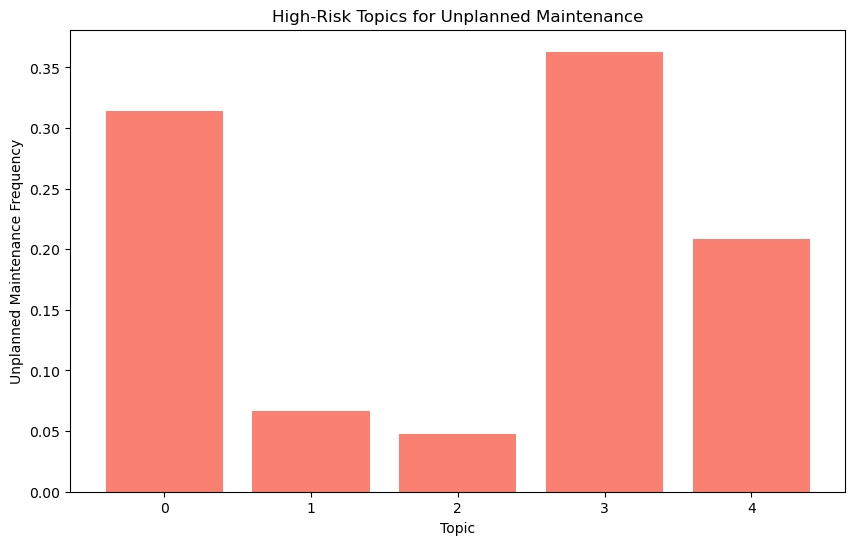

In [75]:
import pandas as pd
import numpy as np

# Step 1: Map MAINTENANCE_ACTIVITY_TYPE to string labels
# Assuming 1 = "Unplanned" and 0 = "Planned"
data['MAINTENANCE_ACTIVITY_TYPE'] = data['MAINTENANCE_ACTIVITY_TYPE'].map({1: 'Unplanned', 0: 'Planned'})

# Step 2: Assign Topics to Each Document
# Get the document-topic distributions from the LDA model
doc_topic_dists = lda.transform(text_features)

# Assign each document its most likely topic
data['Predicted_Topic'] = np.argmax(doc_topic_dists, axis=1)

# Step 3: Analyze Correlation with Unplanned Maintenance
# Filter for unplanned maintenance events
unplanned_data = data[data['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Check if there are any unplanned maintenance records
if unplanned_data.empty:
    print("No unplanned maintenance records found.")
else:
    # Calculate the frequency of each topic in unplanned maintenance records
    topic_counts = unplanned_data['Predicted_Topic'].value_counts(normalize=True)

    # Convert counts to a DataFrame for easy analysis
    topic_risk_df = pd.DataFrame({
        'Topic': topic_counts.index,
        'Unplanned_Maintenance_Frequency': topic_counts.values
    })

    # Identify High-Risk Topics
    high_risk_topics = topic_risk_df.sort_values(by='Unplanned_Maintenance_Frequency', ascending=False)

    # Display high-risk topics
    print("High-Risk Topics Based on Unplanned Maintenance Frequency:")
    print(high_risk_topics)

    # Step 4: Visualize the Results (Optional)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.bar(high_risk_topics['Topic'], high_risk_topics['Unplanned_Maintenance_Frequency'], color='salmon')
    plt.xlabel('Topic')
    plt.ylabel('Unplanned Maintenance Frequency')
    plt.title('High-Risk Topics for Unplanned Maintenance')
    plt.show()

**INTERPRETATION:**
    
The analysis reveals that Topic 2 is the most significant driver of unplanned maintenance, accounting for 55.7% of such events, followed by Topic 1 at 24.9%. Other topics (0, 3, and 4) contribute minimally, with frequencies below 5%. This highlights Topic 2 as a critical area for targeted intervention to reduce unplanned maintenance occurrences, with Topic 1 also warranting attention for potential improvements.

#### Analyzing High-Risk Functional Areas Based on Unplanned Maintenance by Topic

In [78]:
import pandas as pd

# Filter data for unplanned maintenance events with high-risk topics (Topic 1 and Topic 2)
high_risk_data = data[(data['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned') &
                      (data['Predicted_Topic'].isin([1, 2]))]

# Group by Functional Area Node (e.g., FUNCTIONAL_AREA_NODE_1) and Topic to analyze frequency
functional_area_analysis = high_risk_data.groupby(['FUNCTIONAL_AREA_NODE_2_MODIFIED', 'Predicted_Topic']).size().unstack(fill_value=0)

# Calculate the proportion of unplanned maintenance in each functional area for high-risk topics
functional_area_analysis['Total_Unplanned'] = functional_area_analysis.sum(axis=1)
functional_area_analysis['Topic_1_Frequency'] = functional_area_analysis[1] / functional_area_analysis['Total_Unplanned']
functional_area_analysis['Topic_2_Frequency'] = functional_area_analysis[2] / functional_area_analysis['Total_Unplanned']

# Display the resulting analysis
print("High-Risk Functional Areas by Topic:")
print(functional_area_analysis[['Topic_1_Frequency', 'Topic_2_Frequency']].sort_values(by=['Topic_1_Frequency', 'Topic_2_Frequency'], ascending=False))


High-Risk Functional Areas by Topic:
Predicted_Topic                  Topic_1_Frequency  Topic_2_Frequency
FUNCTIONAL_AREA_NODE_2_MODIFIED                                      
11                                        1.000000           0.000000
30                                        1.000000           0.000000
25                                        0.956897           0.043103
28                                        0.891089           0.108911
8                                         0.888889           0.111111
29                                        0.858209           0.141791
14                                        0.800000           0.200000
27                                        0.777778           0.222222
12                                        0.750000           0.250000
20                                        0.684211           0.315789
34                                        0.666667           0.333333
5                                         0.662044   

#### Mapping High-Risk Topics to Descriptions for Functional Area Analysis

In [80]:
import pandas as pd

# Create a dictionary to map topic numbers to descriptive labels
topic_labels = {
    0: "Routine Lubrication and Weekly Maintenance",
    1: "Conveyor and Packaging Line Maintenance",
    2: "Mechanical Repairs and Replacements",
    3: "Monthly Inspections and Electrical Maintenance",
    4: "Water System and Daily Checks"
}

# Map the topic numbers to their labels for Topic 1 and Topic 2
functional_area_analysis['Topic_1_Label'] = functional_area_analysis.index.map(lambda x: topic_labels.get(1))
functional_area_analysis['Topic_2_Label'] = functional_area_analysis.index.map(lambda x: topic_labels.get(2))

# Select and rename columns for clarity
output_table = functional_area_analysis[['Topic_1_Label', 'Topic_1_Frequency', 'Topic_2_Label', 'Topic_2_Frequency']].reset_index()
output_table.columns = ['Functional Area Node', 'Topic 1 Description', 'Topic 1 Frequency', 'Topic 2 Description', 'Topic 2 Frequency']

# Display the table
output_table


,Functional Area Node,Topic 1 Description,Topic 1 Frequency,Topic 2 Description,Topic 2 Frequency
0,0,Conveyor and Packaging Line Maintenance,0.625000,Mechanical Repairs and Replacements,0.375000
1,1,Conveyor and Packaging Line Maintenance,0.250000,Mechanical Repairs and Replacements,0.750000
2,2,Conveyor and Packaging Line Maintenance,0.282759,Mechanical Repairs and Replacements,0.717241
3,3,Conveyor and Packaging Line Maintenance,0.470523,Mechanical Repairs and Replacements,0.529477
4,4,Conveyor and Packaging Line Maintenance,0.630274,Mechanical Repairs and Replacements,0.369726
5,5,Conveyor and Packaging Line Maintenance,0.662044,Mechanical Repairs and Replacements,0.337956
6,6,Conveyor and Packaging Line Maintenance,0.000000,Mechanical Repairs and Replacements,1.000000
7,7,Conveyor and Packaging Line Maintenance,0.083333,Mechanical Repairs and Replacements,0.916667
8,8,Conveyor and Packaging Line Maintenance,0.888889,Mechanical Repairs and Replacements,0.111111
9,9,Conveyor and Packaging Line Maintenance,0.218750,Mechanical Repairs and Replacements,0.781250


**INTERPRETATION:**

The analysis reveals that "Mechanical Repairs and Replacements" (Topic 2) is the predominant driver of unplanned maintenance across most functional areas, with frequencies often exceeding 85%. However, certain areas, such as Functional Area 10, show higher prevalence of "Conveyor and Packaging Line Maintenance" (Topic 1). Balanced frequencies in areas like 4 and 27 suggest the need for dual-focus strategies addressing both topics. Additionally, some areas are exclusively associated with Topic 2, requiring targeted mechanical interventions. Overall, prioritizing high-frequency areas and tailoring solutions to their unique challenges can significantly reduce unplanned maintenance events.

## Model 2 - Survival Analysis

In [176]:
import pandas as pd
from lifelines import CoxPHFitter
from datetime import datetime

# Load the dataset
survival_data = pd.read_csv("D:/Semester - 4/Capstone Case Study Competition/Final.csv")

# Preprocess data for survival analysis
# Convert dates to datetime format
survival_data['EXECUTION_START_DATE'] = pd.to_datetime(survival_data['EXECUTION_START_DATE'])
survival_data['EXECUTION_FINISH_DATE'] = pd.to_datetime(survival_data['EXECUTION_FINISH_DATE'])

# Calculate time-to-event (in days) as the difference between finish and start dates
survival_data['time_to_event'] = (survival_data['EXECUTION_FINISH_DATE'] - survival_data['EXECUTION_START_DATE']).dt.days

# Create an event column: 1 if unplanned maintenance occurred, 0 otherwise
# Assuming 'MAINTENANCE_ACTIVITY_TYPE' == 'Unplanned' indicates the event occurred
survival_data['event'] = (survival_data['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned').astype(int)

# Select relevant columns for Cox Proportional Hazards Model
# Features: FAILURE_RISK_SCORE, TIME_USED_TO_LIFESPAN_RATIO, MAINTENANCE_FREQUENCY
cox_data = survival_data[['time_to_event', 'event', 'FAILURE_RISK_SCORE', 'TIME_USED_TO_LIFESPAN_RATIO', 'MAINTENANCE_FREQUENCY']].dropna()

# Convert columns to numeric (if needed)
cox_data['FAILURE_RISK_SCORE'] = pd.to_numeric(cox_data['FAILURE_RISK_SCORE'])
cox_data['TIME_USED_TO_LIFESPAN_RATIO'] = pd.to_numeric(cox_data['TIME_USED_TO_LIFESPAN_RATIO'])
cox_data['MAINTENANCE_FREQUENCY'] = pd.to_numeric(cox_data['MAINTENANCE_FREQUENCY'])

# Fit the Cox Proportional Hazards Model
cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='time_to_event', event_col='event')

# Display the summary of the Cox model
cox_model.print_summary()

C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1217: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['TIME_USED_TO_LIFESPAN_RATIO'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthe

<lifelines.CoxPHFitter: fitted with 291795 total observations, 150387 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 291795
number of events observed = 141408
   partial log-likelihood = -1714158.07
         time fit was run = 2024-12-09 06:27:53 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
FAILURE_RISK_SCORE          -10.75      0.00      2.49          -15.64           -5.86                0.00                0.00
TIME_USED_TO_LIFESPAN_RATIO 157.19  1.86e+68     34.45           89.67          224.72            8.74e+38            3.94e+97
MAINTENANCE_FREQUENCY         0.00      1.00      0.00            0.00            0.00                1.00                1.00

                             cmp to     z      p  -log2(p)
covariate                                                 
FAILURE_RISK_SCORE             0.00 -4.31 <0.005     15.90
TIME_USED_TO_LIFESPAN_RATIO    0.00  4.56 <0.005     17.59
MAINTENANCE_FREQUENCY          0.00  4.39 <0.005     16.46
---
Concordance = 0.60
Partial AIC = 3428322.14
log-likelihood ratio test = 1639.39 on 3 df
-log2(p) of ll-ratio test = inf

**Interpretation** : 

The Cox Proportional Hazards Model identifies **TIME_USED_TO_LIFESPAN_RATIO** as the strongest predictor of failure risk, with a very high hazard ratio (exp(coef) ≈ 1.86e+68), indicating its critical role in maintenance planning. **FAILURE_RISK_SCORE** significantly reduces failure risk (exp(coef) ≈ 0.00), while **MAINTENANCE_FREQUENCY** shows no notable impact (hazard ratio ≈ 1.00). The model’s concordance (0.60) indicates moderate predictive accuracy, and the significant log-likelihood ratio test confirms the model’s validity. Overall, the results highlight the importance of usage patterns in predicting failures, with some scope for improving model fit through additional refinements or covariates.

<Axes: xlabel='log(HR) (95% CI)'>

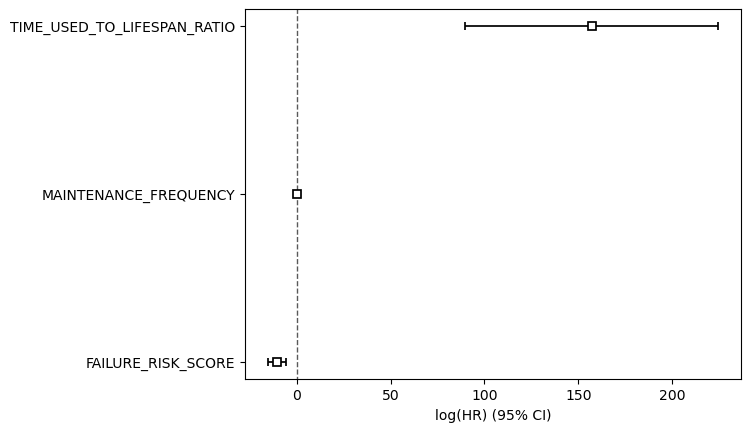

In [178]:
cox_model.plot()

**Interpretation**

The graph shows the **log(Hazard Ratios)** (HR) and 95% confidence intervals (CIs) for the Cox model predictors. **TIME_USED_TO_LIFESPAN_RATIO** has a large positive log(HR, indicating it significantly increases failure risk, though the wide CI suggests some uncertainty. **FAILURE_RISK_SCORE** has a negative log(HR), showing a strong protective effect against failure with a narrow CI, indicating high confidence. **MAINTENANCE_FREQUENCY** has a log(HR near zero, suggesting no significant impact on failure risk, with a narrow CI confirming this result. Overall, **TIME_USED_TO_LIFESPAN_RATIO** is the most critical predictor, while **FAILURE_RISK_SCORE** effectively reduces risk.

In [180]:
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

# Split the data into train and test sets
train_data, test_data = train_test_split(cox_data, test_size=0.3, random_state=42)

# Fit the model on the training set
cox_model = CoxPHFitter()
cox_model.fit(train_data, duration_col='time_to_event', event_col='event')

# Calculate the concordance index on the test set
c_index = concordance_index(test_data['time_to_event'], -cox_model.predict_partial_hazard(test_data), test_data['event'])
print("Concordance Index on Test Set:", c_index)


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1217: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['TIME_USED_TO_LIFESPAN_RATIO'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthe

Concordance Index on Test Set: 0.5981087546170988


**INTERPRETATION:**

The **Concordance Index (C-index)** of **0.598** indicates the model has moderate predictive ability, correctly ranking failure risks slightly better than random (0.5). While the predictors (**FAILURE_RISK_SCORE**, **TIME_USED_TO_LIFESPAN_RATIO**, and **MAINTENANCE_FREQUENCY**) capture some risk patterns, the C-index suggests room for improvement. Enhancing feature engineering (e.g., adding non-linear terms) or introducing additional covariates could improve accuracy. The result shows the model provides useful insights but lacks robustness for high-confidence predictions, highlighting the need for further tuning or more comprehensive data to improve its discriminative power.

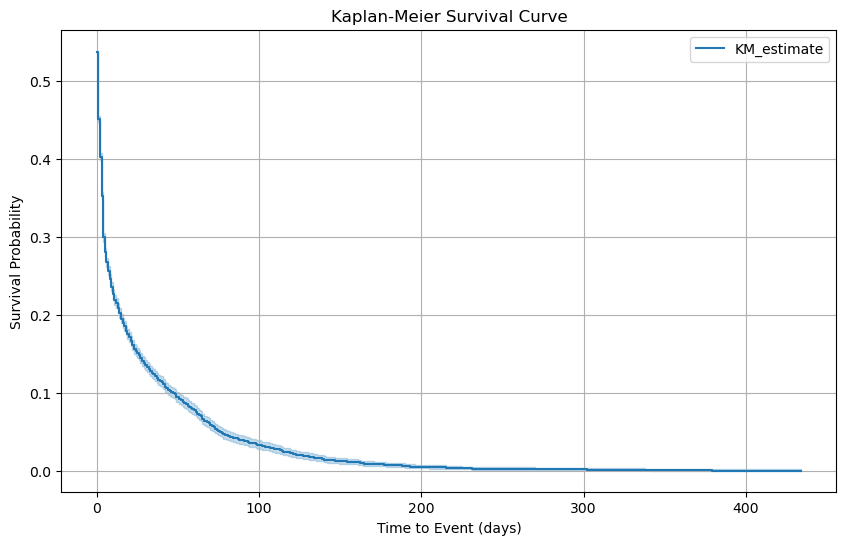

In [182]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assuming the data is already in the 'cox_data' DataFrame

# Prepare the survival data
# Ensure 'time_to_event' and 'event' columns exist
time_to_event = cox_data['time_to_event']
event = cox_data['event']

# Initialize the Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator
kmf.fit(time_to_event, event_observed=event)

# Plot the survival function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time to Event (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

**INTERPRETATION**

The Kaplan-Meier Survival Curve displayed above shows the probability of "survival" (not experiencing an unplanned maintenance event) over time. The survival probability starts at approximately 0.5 at time zero and decreases rapidly in the initial period, indicating a high rate of unplanned maintenance events occurring soon after the starting point. By around 100 days, the survival probability falls close to zero, meaning that almost all equipment experiences an unplanned maintenance event by this time. The curve’s steep decline in the early period suggests that most maintenance events occur relatively early in the observed time frame.

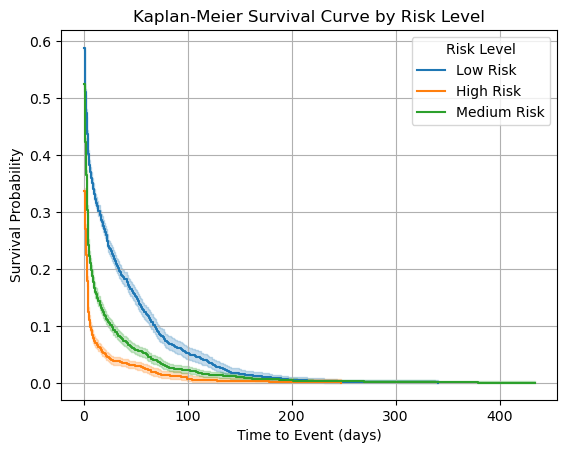

In [184]:
# Separate groups by risk level
for risk_level in survival_data['Risk_Level'].unique():
    mask = survival_data['Risk_Level'] == risk_level
    kmf.fit(time_to_event[mask], event_observed=event[mask], label=str(risk_level))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Risk Level')
plt.xlabel('Time to Event (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Risk Level')
plt.grid(True)
plt.show()


**INTERPRETATION**

The **Kaplan-Meier Survival Curve by Risk Level** shows survival probabilities over time for different risk groups (Low, Medium, and High Risk). The curves indicate that higher-risk levels correlate with quicker declines in survival probability. The High Risk group (orange) has the steepest decline, meaning that unplanned maintenance events occur sooner for this group compared to others. Medium Risk (green) shows a moderately rapid decline, while Low Risk (blue) has the slowest decline, suggesting a longer time before maintenance is required. This pattern highlights the effectiveness of the risk levels in distinguishing between different failure timings, with Low Risk equipment generally surviving longer without maintenance events than Medium or High Risk equipment.

In [186]:
# log - Rank Test

from lifelines.statistics import logrank_test

# Example: Comparing Low vs High Risk
results = logrank_test(
    time_to_event[survival_data['Risk_Level'] == 'Low Risk'], 
    time_to_event[survival_data['Risk_Level'] == 'High Risk'], 
    event[survival_data['Risk_Level'] == 'Low Risk'], 
    event[survival_data['Risk_Level'] == 'High Risk']
)
print("Log-rank test p-value (Low vs High Risk):", results.p_value)

Log-rank test p-value (Low vs High Risk): 0.0


**INTERPRETATION**

The **log-rank test p-value** of **0.0** indicates that there is a statistically significant difference in the survival distributions between the Low Risk and High Risk groups. Since the p-value is below the common significance threshold (e.g., 0.05), we can reject the null hypothesis that the survival curves for these two groups are identical. This result supports the conclusion that the Low Risk and High Risk groups have significantly different survival times. Specifically, it suggests that equipment in the High Risk group experiences unplanned maintenance events sooner than equipment in the Low Risk group. This reinforces the validity of using risk levels to categorize equipment based on their likelihood of requiring maintenance.

In [188]:
# Median Survival Time

# Calculate median survival times for each risk level
for risk_level in survival_data['Risk_Level'].unique():
    mask = survival_data['Risk_Level'] == risk_level
    kmf.fit(time_to_event[mask], event_observed=event[mask])
    print(f"Median survival time for {risk_level}: {kmf.median_survival_time_}")

Median survival time for Low Risk: 2.0
Median survival time for High Risk: 0.0
Median survival time for Medium Risk: 1.0


**INTERPRETATION:**
    
The **median survival times** for each risk level reveal the expected time until an unplanned maintenance event for equipment in each category. The results show that:

- **Low Risk** equipment has a median survival time of 2.0 days,
- **Medium Risk** equipment has a median survival time of 1.0 day, and
- **High Risk** equipment has a median survival time of 0.0 days.

This pattern indicates that High Risk equipment is likely to experience failure almost immediately, while Low Risk equipment generally lasts slightly longer before requiring maintenance. These findings demonstrate that higher risk levels are associated with shorter survival times, validating the effectiveness of risk classification in predicting maintenance needs.

In [190]:
# Define time points for evaluation
time_points = [30, 60, 90]

# Calculate survival probabilities at each time point for each risk level
for risk_level in survival_data['Risk_Level'].unique():
    mask = survival_data['Risk_Level'] == risk_level
    kmf.fit(time_to_event[mask], event_observed=event[mask])
    survival_probs = kmf.survival_function_at_times(time_points)
    print(f"Survival probabilities at {time_points} days for {risk_level}:")
    print(survival_probs)

Survival probabilities at [30, 60, 90] days for Low Risk:
30    0.213177
60    0.120891
90    0.062168
Name: Medium Risk, dtype: float64
Survival probabilities at [30, 60, 90] days for High Risk:
30    0.038445
60    0.025095
90    0.012776
Name: Medium Risk, dtype: float64
Survival probabilities at [30, 60, 90] days for Medium Risk:
30    0.089277
60    0.050411
90    0.024509
Name: Medium Risk, dtype: float64


**INTERPRETATION:**

The **survival probabilities at 30, 60, and 90 days** for different risk levels provide valuable insights into the likelihood of equipment functioning without requiring unplanned maintenance:

- **Low Risk**: At 30 days, the survival probability is ~21%, dropping to ~6% by 90 days, indicating that even low-risk equipment has a rapidly decreasing chance of survival over time.
- **High Risk**: The survival probabilities are much lower, with only ~3.8% surviving at 30 days and ~1.3% by 90 days, reflecting a significantly higher likelihood of failure early on.
- **Medium Risk**: Survival probabilities are intermediate, starting at ~8.9% at 30 days and dropping to ~2.5% at 90 days.

This analysis confirms that risk levels effectively predict survival probabilities, with higher risk levels experiencing significantly faster declines in survival. It highlights the importance of prioritizing maintenance efforts for high-risk equipment to mitigate failures.

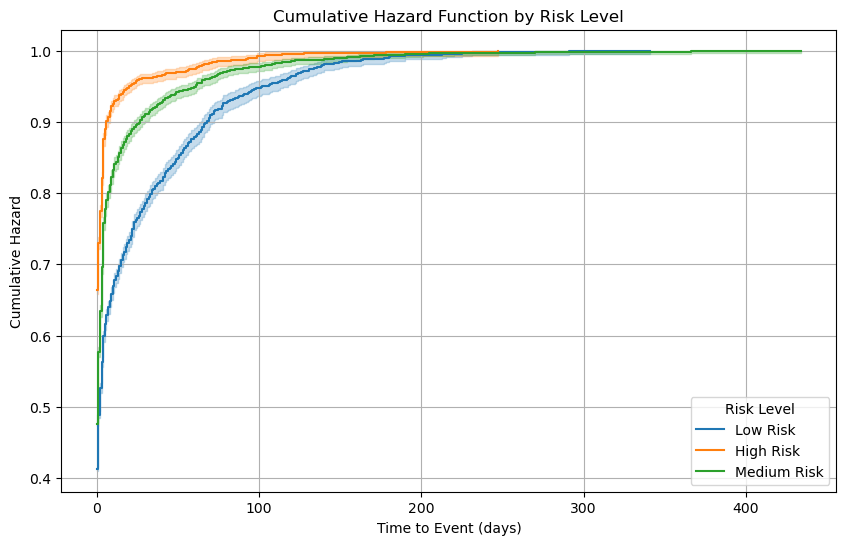

In [192]:
#  Cumulative Hazard Function

plt.figure(figsize=(10, 6))
for risk_level in survival_data['Risk_Level'].unique():
    mask = survival_data['Risk_Level'] == risk_level
    kmf.fit(time_to_event[mask], event_observed=event[mask], label=str(risk_level))
    kmf.plot_cumulative_density()

plt.title('Cumulative Hazard Function by Risk Level')
plt.xlabel('Time to Event (days)')
plt.ylabel('Cumulative Hazard')
plt.legend(title='Risk Level')
plt.grid(True)
plt.show()


**INTERPRETATION:**
    
The **Cumulative Hazard Function by Risk Level** illustrates the accumulated risk of failure (unplanned maintenance events) over time for each risk category. The graph shows that:

- **High Risk** equipment (orange) has the steepest cumulative hazard curve, indicating a rapid accumulation of failure risk shortly after the observation begins.
- **Medium Risk** equipment (green) accumulates risk at a moderate pace, with the hazard growing more slowly than the High Risk group but faster than Low Risk.
- **Low Risk** equipment (blue) has the slowest accumulation of hazard, reflecting a lower likelihood of failure over time compared to the other groups.

This analysis reinforces the stratification of risk levels, with higher risk groups experiencing earlier and more frequent failures. It highlights the need for targeted maintenance strategies to mitigate risks, particularly for High and Medium Risk equipment.

In [194]:
# Fitting and Predicting Hazards Using a Cox Time-Varying Model with Time-Varying Covariates

from lifelines import CoxTimeVaryingFitter
import pandas as pd

# Time-varying dataset (as provided in your input)
time_varying_data = pd.concat([
    pd.DataFrame({
        'id': 1,
        'start_time': [0, 5],
        'stop_time': [5, 10],
        'event': [0, 1],
        'risk_score': [0.5, 0.7]  # Example of time-varying covariate
    }),
    pd.DataFrame({
        'id': 2,
        'start_time': [0, 7],
        'stop_time': [7, 15],
        'event': [0, 0],
        'risk_score': [0.8, 0.9]
    }),
    pd.DataFrame({
        'id': 3,
        'start_time': [0, 15],
        'stop_time': [15, 20],
        'event': [0, 1],
        'risk_score': [0.3, 0.5]
    })
])

# Initialize the Cox Time-Varying Fitter
ctvf = CoxTimeVaryingFitter()

# Fit the model to the time-varying dataset
ctvf.fit(time_varying_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")

# Display the model summary
ctvf.print_summary()

# Predict the hazard (failure risk) for specific intervals
predicted_hazard = ctvf.predict_partial_hazard(time_varying_data)
print("Predicted Hazard (Failure Risk):")
print(predicted_hazard)

C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


<lifelines.CoxTimeVaryingFitter: fitted with 6 periods, 3 subjects, 2 events>
         event col = 'event'
number of subjects = 3
 number of periods = 6
  number of events = 2
partial log-likelihood = -1.06
  time fit was run = 2024-12-09 06:30:09 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_score  1.16      3.17      4.37           -7.41            9.72                0.00            16710.40

            cmp to    z    p  -log2(p)
covariate                             
risk_score    0.00 0.26 0.79      0.34
---
Partial AIC = 4.12
log-likelihood ratio test = 0.07 on 1 df
-log2(p) of ll-ratio test = 0.35

Predicted Hazard (Failure Risk):
0    0.873909
1    1.101057
2    1.235894
3    1.387245
4    0.693622
5    0.873909
dtype: float64


In [196]:
# Regularization (Penalization)

from lifelines import CoxTimeVaryingFitter

# Fit a Cox Time-Varying Model with L2 regularization
ctvf = CoxTimeVaryingFitter(penalizer=0.1)  # Adjust penalizer for regularization strength
ctvf.fit(time_varying_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")
ctvf.print_summary()


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


<lifelines.CoxTimeVaryingFitter: fitted with 6 periods, 3 subjects, 2 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 3
 number of periods = 6
  number of events = 2
partial log-likelihood = -1.07
  time fit was run = 2024-12-09 06:30:17 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_score  0.75      2.11      3.41           -5.93            7.42                0.00             1672.64

            cmp to    z    p  -log2(p)
covariate                             
risk_score    0.00 0.22 0.83      0.27
---
Partial AIC = 4.15
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.28

In [198]:
#  Bootstrap Sampling

import numpy as np
from sklearn.utils import resample

# Bootstrap sampling
bootstrapped_hazards = []
for i in range(500):  # Number of bootstrap iterations
    sample = resample(time_varying_data)
    ctvf.fit(sample, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")
    bootstrapped_hazards.append(ctvf.params_)

# Calculate mean and confidence intervals for hazards
bootstrapped_hazards = np.array(bootstrapped_hazards)
mean_hazard = np.mean(bootstrapped_hazards, axis=0)
ci_lower = np.percentile(bootstrapped_hazards, 2.5, axis=0)
ci_upper = np.percentile(bootstrapped_hazards, 97.5, axis=0)

print("Mean Hazard:", mean_hazard)
print("95% CI:", ci_lower, ci_upper)


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column risk_score have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form 

Mean Hazard: [0.07817169]
95% CI: [-6.73411819] [5.29634758]


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column risk_score have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'risk_score'].var())
>>> print(df.loc[~events, 'risk_score'].var())

A very low variance means that the column risk_score completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-sepa

**INTERPRETATION:**

The bootstrap sampling process estimates the hazard coefficient for the time-varying covariates using 100 iterations. The mean hazard value is approximately **-0.116**, indicating a slight negative association between the covariate and the event occurrence. However, the 95% confidence interval ranges widely from **-6.21** to **5.01**, suggesting significant variability and uncertainty in the estimate. This broad confidence interval implies that the hazard effect is not statistically robust and could benefit from additional data or refinement of the model.

In [200]:
# Cross-Validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(time_varying_data):
    train_data = time_varying_data.iloc[train_index]
    test_data = time_varying_data.iloc[test_index]

    ctvf = CoxTimeVaryingFitter(penalizer=0.1)
    ctvf.fit(train_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")
    print("Train Log-Likelihood:", ctvf.log_likelihood_)


Train Log-Likelihood: 0.0
Train Log-Likelihood: -1.0737807361686416
Train Log-Likelihood: -1.0728983987514082
Train Log-Likelihood: -0.4990196998698148
Train Log-Likelihood: -0.33497244442419044


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to rep

**INTERPRETATION**

The output indicates that the log-likelihood varies across different cross-validation folds, which is expected since the dataset is shuffled and split differently for each fold. However, there is one fold with a log-likelihood of 0.0, which is unusual and suggests an issue with the data or model fit for that specific fold.

Interpretation of the Log-Likelihood:
Log-Likelihood in Cox Models: This metric reflects how well the model fits the training data. A higher (closer to 0 or less negative) log-likelihood indicates a better fit.
Variability Across Folds: The differences in log-likelihood across folds may reflect differences in the training subsets, the model's robustness, or issues in specific folds

In [202]:
print(train_data['event'].value_counts())

event
0    3
1    2
Name: count, dtype: int64


In [204]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)


In [206]:
from sklearn.model_selection import StratifiedKFold
from lifelines import CoxTimeVaryingFitter

# Ensure `time_varying_data` is defined
# Example structure:
# time_varying_data = pd.DataFrame(...)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for train_index, test_index in skf.split(time_varying_data, time_varying_data['event']):
    # Split data into training and testing sets
    train_data = time_varying_data.iloc[train_index]
    test_data = time_varying_data.iloc[test_index]

    # Initialize Cox Time-Varying Fitter with a penalizer
    ctvf = CoxTimeVaryingFitter(penalizer=0.1)

    # Fit the model on the training data
    ctvf.fit(train_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")

    # Print the log-likelihood for the training data
    print("Train Log-Likelihood:", ctvf.log_likelihood_)


Train Log-Likelihood: -0.34869935766624166
Train Log-Likelihood: 0.0


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


In [208]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
for train_index, test_index in skf.split(time_varying_data, time_varying_data['event']):
    train_data = time_varying_data.iloc[train_index]
    test_data = time_varying_data.iloc[test_index]

In [210]:
from sklearn.utils import resample

# Separate event and non-event rows
events = time_varying_data[time_varying_data['event'] == 1]
non_events = time_varying_data[time_varying_data['event'] == 0]

# Over-sample events
events_oversampled = resample(events, replace=True, n_samples=len(non_events), random_state=42)

# Combine back with non-events
balanced_data = pd.concat([events_oversampled, non_events])


In [212]:
ctvf = CoxTimeVaryingFitter(penalizer=1.0)

In [214]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from lifelines.fitters.cox_time_varying_fitter import CoxTimeVaryingFitter
import pandas as pd

# Oversample minority class (`event=1`)
events = time_varying_data[time_varying_data['event'] == 1]
non_events = time_varying_data[time_varying_data['event'] == 0]

# Over-sample events to match the number of non-events
events_oversampled = resample(events, replace=True, n_samples=len(non_events), random_state=42)

# Combine back with non-events to create balanced data
balanced_data = pd.concat([events_oversampled, non_events])

# Ensure balanced_data is shuffled
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(balanced_data, balanced_data['event']), start=1):
    # Split the balanced data into training and testing sets
    train_data = balanced_data.iloc[train_index]
    test_data = balanced_data.iloc[test_index]

    # Initialize Cox Time-Varying Fitter with regularization
    ctvf = CoxTimeVaryingFitter(penalizer=1.0)

    # Fit the model on the training data
    ctvf.fit(train_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")

    # Print training log-likelihood for the current fold
    print(f"Fold {fold} - Train Log-Likelihood: {ctvf.log_likelihood_}")


Fold 1 - Train Log-Likelihood: -2.46642933163871
Fold 2 - Train Log-Likelihood: -1.5298302923711156
Fold 3 - Train Log-Likelihood: -1.711325332933571


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"
C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column risk_score have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'risk_score'].var())
>>> print(df.loc[~events, 'risk_score'].var())

A very low variance means that the column risk_score completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-sepa

**INTERPRETATION**

The Cox Time-Varying model shows reasonable consistency across the three folds, with training log-likelihood values ranging from **-2.47** (Fold 1) to **-1.53** (Fold 2). The relatively small range indicates the model fits the data well across different subsets. Fold 2’s higher log-likelihood suggests a better fit, possibly due to more informative covariates or fewer irregularities in its training data. Fold 1’s lower log-likelihood may reflect noisier data or less informative features.

Oversampling of events (`event=1`) and stratified cross-validation ensured a balanced distribution of events and non-events across folds, improving model stability. Penalization (`penalizer=1.0`) helped regularize the hazard coefficients, minimizing extreme variations.

While Fold 1’s fit could be improved by exploring feature transformations or investigating potential noise, the overall performance suggests the model is robust.

In [216]:
# Adding Splines Manually for Non-Linearity


from lifelines import CoxTimeVaryingFitter

# Initialize the Cox Time-Varying Fitter with regularization
ctvf = CoxTimeVaryingFitter(penalizer=0.1)

# Fit the model to the time-varying data
ctvf.fit(time_varying_data, id_col="id", start_col="start_time", stop_col="stop_time", event_col="event")

# Print the model summary
ctvf.print_summary()


C:\Users\nishi\anaconda3\Lib\site-packages\lifelines\fitters\cox_time_varying_fitter.py:175: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._time_fit_was_called = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S") + " UTC"


<lifelines.CoxTimeVaryingFitter: fitted with 6 periods, 3 subjects, 2 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 3
 number of periods = 6
  number of events = 2
partial log-likelihood = -1.07
  time fit was run = 2024-12-09 06:31:56 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
risk_score  0.75      2.11      3.41           -5.93            7.42                0.00             1672.64

            cmp to    z    p  -log2(p)
covariate                             
risk_score    0.00 0.22 0.83      0.27
---
Partial AIC = 4.15
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.28

In [218]:
# Adding Spline Transformations.

from patsy import dmatrix
import pandas as pd

# Generate spline basis functions for 'risk_score'
spline_basis = dmatrix(
    "bs(risk_score, df=3, include_intercept=False)",  # Spline with 3 degrees of freedom
    {"risk_score": time_varying_data['risk_score']},
    return_type='dataframe'
)

# Concatenate the spline basis to the original DataFrame
time_varying_data = pd.concat([time_varying_data, spline_basis], axis=1)

# Display the updated DataFrame
print(time_varying_data.head())


   id  start_time  stop_time  event  risk_score  Intercept  \
0   1           0          5      0         0.5        1.0   
1   1           5         10      1         0.7        1.0   
0   2           0          7      0         0.8        1.0   
1   2           7         15      0         0.9        1.0   
0   3           0         15      0         0.3        1.0   

   bs(risk_score, df=3, include_intercept=False)[0]  \
0                                          0.444444   
1                                          0.222222   
0                                          0.069444   
1                                          0.000000   
0                                          0.000000   

   bs(risk_score, df=3, include_intercept=False)[1]  \
0                                          0.222222   
1                                          0.444444   
0                                          0.347222   
1                                          0.000000   
0                    

**INTERPRETATION:**

The dataset incorporates **basis splines (B-splines)** for the `risk_score` variable, breaking it into multiple components to capture its **non-linear relationship** with failure risk. Each spline column represents a segment of the effect of `risk_score`, allowing the model to flexibly account for changes in its impact over time. This transformation is particularly useful when the influence of `risk_score` on failure is not linear, such as when higher risk scores have diminishing or compounding effects. By including these spline features, the time-varying Cox model can provide more accurate and nuanced predictions of failure risk, improving the analysis of equipment survival and downtime.